<a href="https://colab.research.google.com/github/cssavi/ConocoPhillipsML/blob/main/ConocoPhillips_ML_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objectives and Project Description**



In this notebook, our goal was to create models of varying complexity and then predict energy demand. We created predictions using the following models:

*   ARIMA
*   SARIMA
*   Prophet
*   VAR

We used two datasets. One is energy demand by the hour, obtained from ERCOT's website, and the other is temperature by the hour, obtained from World Weather API. Scripts used to obtain and clean this data are not contained within this notebook, though could be provided if requested.




**Method Description**

This is a brief run-down of what we did to accomplish the various models. 

We began by obtaining, parsing, and cleaning the energy demand data. This involved creating functions to find irregularities and join together data from disparate spreadsheets. We further performed hour corrections and column relabeling. We followed a similar process for the weather data. Next, we did basic data analytics by plotting data and observing trends/irregularities. Afterwards, we imported the required packages and ran ARIMA, SARIMA, Prophet, and VAR models and began working on them.

For our ARIMA model, we performed stationarity tests (eg, the Dickey-Fuller Hypothesis test), but did little else before feeding in the data. 
For our SARIMA model, we performed a monthly cumulative sum. We initially tried doing seasonal decompositions, but realized it was unnecessary. Fortunately, however, the decomposition would prove useful for the VAR model.
For our Prophet model, we simply re-named the axes to 'ds' and 'y' as required, with very little other changes.
For the VAR model, we again performed stationarity tests and then also did seasonal decompositions.

**Functions Section**

We used the adfuller() function to verify that our input data for the VAR model was stationary.

We used the auto_arima() function in order to perform a grid search for hyperparameters to optimize our SARIMA model. We used the same function for our ARIMA model as well.

We used the fit() and predict() functions to create our prophet model

We used the seasonal_decompose() function to fix our seasonal decompose code

We used the VAR() function in order to create our bivariate Vector Autoregression model with temperature and energy demand.

**Workflow**

Current Workflow:
First we checked the pre-assumptions for each model and created residual plots. Then we performed principal component analysis on each model and made a QQ plot to test if the data is actually normal. We tested several metrics and visually inspected our data. And of course, we used mean square error to test accuracy. At this time we decided on an 80-20 split between training and testing data.*
Finally, we created confidence intervals on our data before we begin testing our models.
 
The first model we created was a SARIMA model on Energy Demand as it is an univariate model. We did some hyperparamater tuning and used grid search from the sklearn library. The second model we used was the prophet model by facebook. We decomposed the time series and completed forecasing, confidence intervals, and made checkpoints. After trying these univariate models we moved on to attempting some multivariate models to account for both the temperature and energy demand data.
 
- Effectively, we did a comparison of 5 different approaches:
 - ARIMA Univariate (Energy Demand)
 - SARIMA Univariate (Energy Demand)
 - Prophet Univariate (Energy Demand)
 - VAR Bivariate (Energy Demand and Temperature)
 - Prophet Bivariate (Energy Demand and Temperature)

**Results and Conclusions**

In summary, we found the Prophet Univariate model to be the best, producing the lowest RMSE value when compared to its testing data. We suspect that this is due to the fact that prophet is a very robust model, and that the univariate model had access to more data. One possibility though is that temperature data is very stationary, which prevented the bivariate model from inferring the slightly upwards trend. 

The two cells below code for imports, including importing from our shared google drive, as well as imports which are borrowed from the correlation coefficient jupyter notebook by Dr. Michael Pyrcz. 

If you would like to use this code, please go to this link: https://drive.google.com/drive/folders/1tpIRJ8NHJ7Tc3c82SigW_ag2k4MBcWzP?usp=sharing 

In order to run the code, please add a shortcut to this drive folder into your personal drive account.  At that point, you can mount your own drive and use the code the same way we can. This is a link to a drive containing the same file hierarchy we use, but only with files that are necessary to run the code, and is currently public. This link is not future-safe, because we will not be adding files to this drive. 

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
##Copied all the imports from the correlation coefficient jupyter notebook provided by Jose & Michael Pyrcz
%matplotlib inline
import os                                               # to set current working directory 
import sys                                              # supress output to screen for interactive variogram modeling
import json
import csv
import io
import numpy as np                                      # arrays and matrix math
import pandas as pd                                     # DataFrames
import matplotlib.pyplot as plt                         # plotting
from matplotlib.pyplot import cm                        # color maps
from matplotlib.patches import Ellipse                  # plot an ellipse
import math                                             # sqrt operator
import random                                           # random simulation locations
from copy import copy                                   # copy a colormap
from scipy.stats import norm
from ipywidgets import interactive                      # widgets and interactivity
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox
from scipy.stats import norm                            # Gaussian distribution
import scipy.stats as st                                # statistical methods
#!pip uninstall pmdarima
!pip install pmdarima
import pmdarima as pm                                   #SARIMA Grid Search

#Additional imports copied from Time Series jupyter notebook provided by Michael Pyrcz
#import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic

import datetime

     |████████████████████████████████| 1.4 MB 31.8 MB/s 
     |████████████████████████████████| 9.8 MB 45.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


Prints the 2021 Energy Demand data recorded by the hour in a spreadsheet. 

It additionally prints out some univariate statistics for the data, assisting us with analysis to be performed next week.

Now, this code has been updated to read in all of the energy demand data since 2003

In [ ]:
dfs = pd.DataFrame()
COLLABELS = ['Hour Ending', 'COAST', 'EAST', 'FWEST', 'NORTH', 'NCENT', 'SOUTH', 'SCENT', 'WEST', 'ERCOT']

dfs = pd.read_excel("/content/drive/MyDrive/FRI-Group_3/EnergyDemandXLSXFiles/ConsolidatedEnergyDemandData.xlsx")

print("Univariate Statistics Data Summary: ")
dfs.describe()

Univariate Statistics Data Summary: 


COAST           EAST  ...           WEST          ERCOT
count  162886.000000  162886.000000  ...  162886.000000  162886.000000
mean    10898.603730    1402.228293  ...    1063.473072   37892.450768
std      2647.869169     334.787780  ...     254.866590    9548.037088
min      1702.829343     737.857378  ...     525.299257   19269.758294
25%      8994.007657    1168.976161  ...     877.100686   31043.281711
50%     10350.869571    1331.487679  ...    1022.257306   35979.346736
75%     12359.625127    1583.954649  ...    1205.575504   43022.528492
max     21256.115190    2949.198517  ...    2117.399078   74665.579486

[8 rows x 9 columns]

Hypothesis Test For Stationarity. Code credit goes to Michael Pyrcz

In [ ]:
print('Dickey-Fuller Test Results:')
# We ran the dickey-fuller test and got the results 
dblcheckdfs = dfs.dropna()
dblcheckdfs = dblcheckdfs.reset_index(drop=True)
for col in COLLABELS:
  if(col!='Hour Ending'):
    demand = dblcheckdfs[col]

    dftest = adfuller(demand, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(col + " Test results: ")
    print(dfoutput[0:7])


Dickey-Fuller Test Results:
COAST Test results: 
Test Statistic                -1.162743e+01
p-value                        2.305552e-21
#Lags Used                     7.700000e+01
Number of Observations Used    1.628080e+05
Critical Value (1%)           -3.430390e+00
Critical Value (5%)           -2.861558e+00
Critical Value (10%)          -2.566779e+00
dtype: float64
EAST Test results: 
Test Statistic                -1.667423e+01
p-value                        1.535681e-29
#Lags Used                     7.700000e+01
Number of Observations Used    1.628080e+05
Critical Value (1%)           -3.430390e+00
Critical Value (5%)           -2.861558e+00
Critical Value (10%)          -2.566779e+00
dtype: float64
FWEST Test results: 
Test Statistic                     -2.447164
p-value                             0.128865
#Lags Used                         77.000000
Number of Observations Used    162808.000000
Critical Value (1%)                -3.430390
Critical Value (5%)                -2.8

Since the p-value is below the alpha-level of 5% in all cases excepting the FWEST region, we reject the null hypothesis for all regions but FWEST. Therefore, we must try to decompose the trend for the FWEST region, but the others can be safely assumed as stationary. However, for the sake of thoroughness, we went ahead and applied the decomposition to all of the demand data. Code credit again goes to Michael Pyrcz

Since energy demand is reliant on the time of day, day of week, and day of year, we must perform a complex seasonal decomposition.
Additionally, we will detrend the data through a simple linear regression. In the future, we should look for a more complex strategy

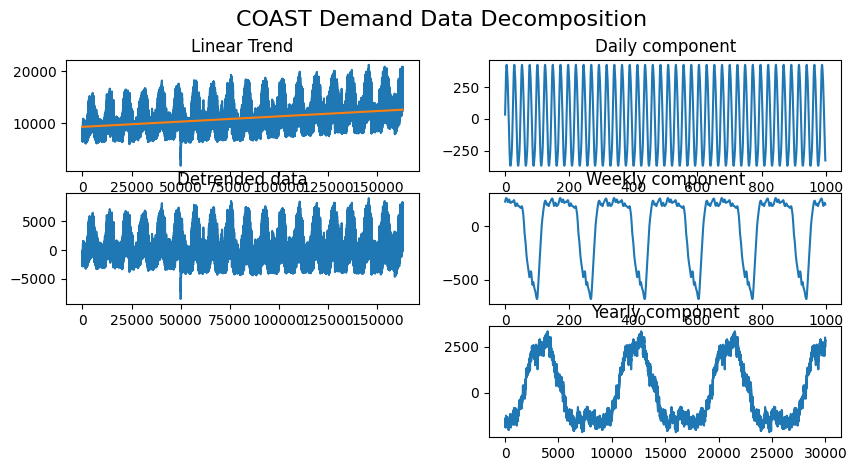

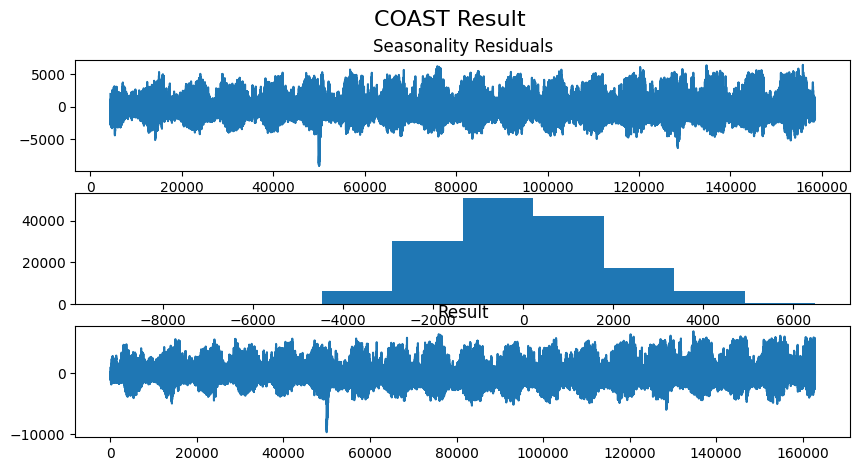

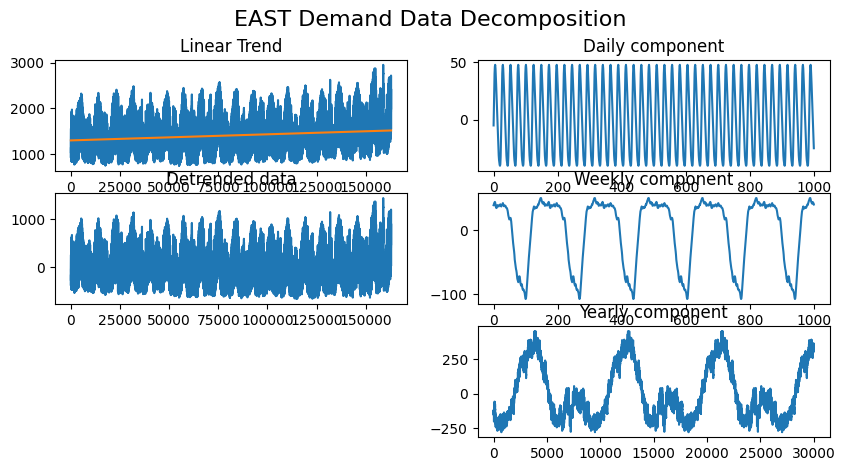

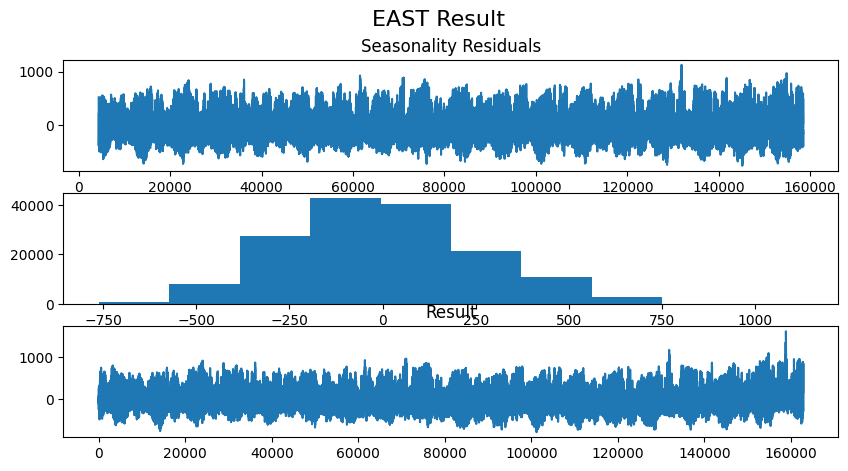

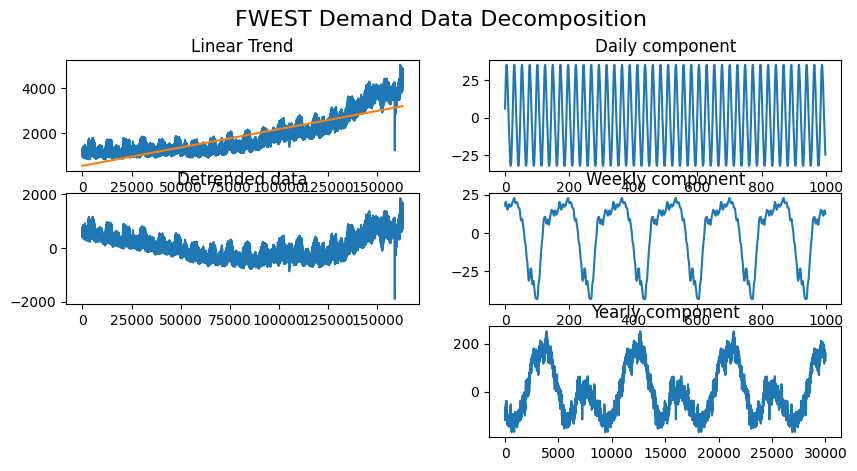

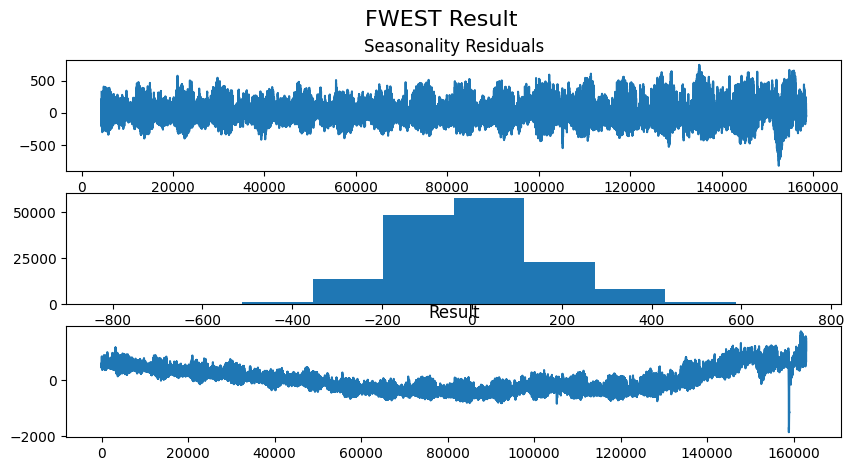

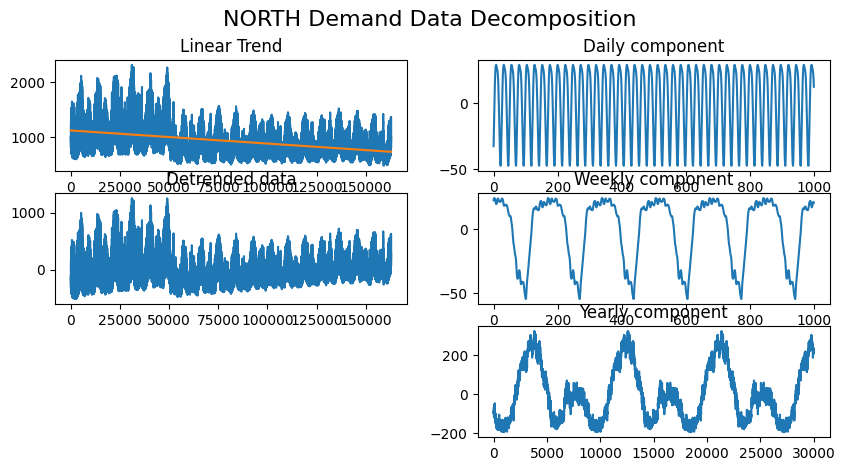

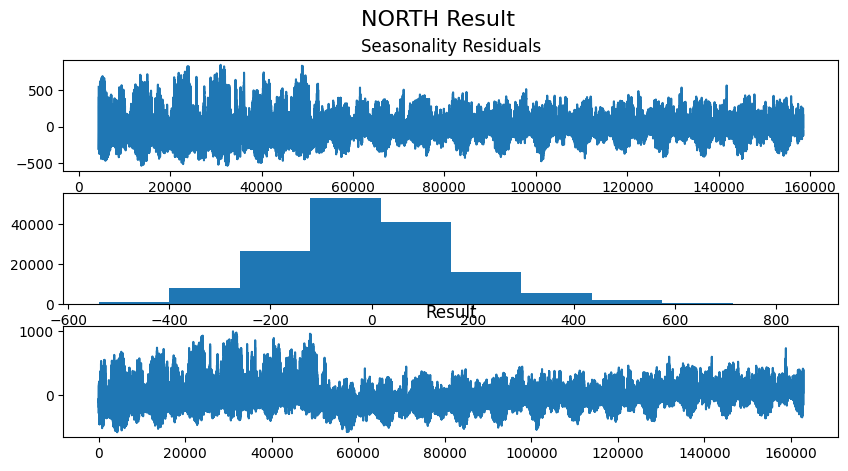

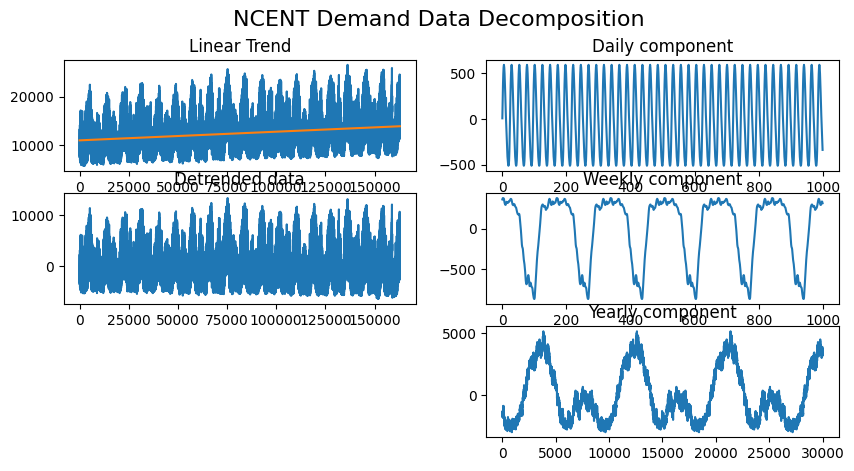

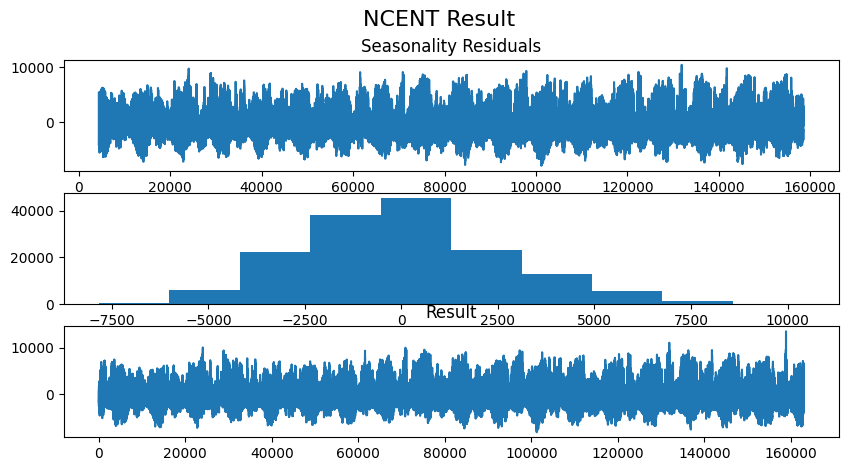

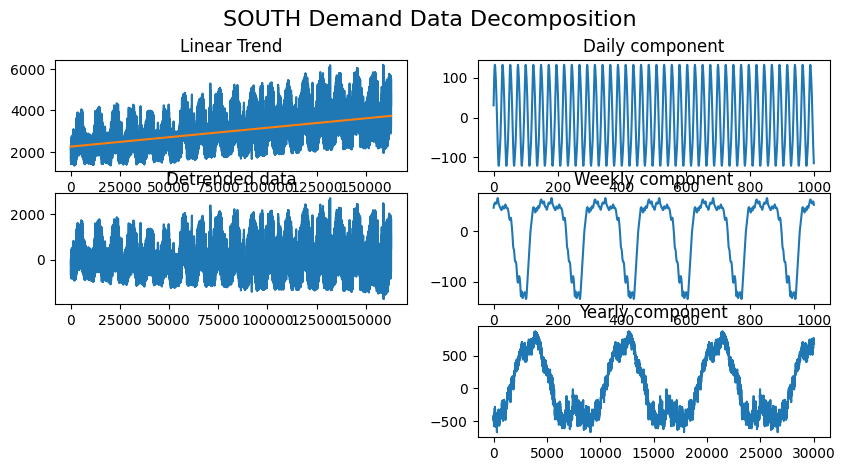

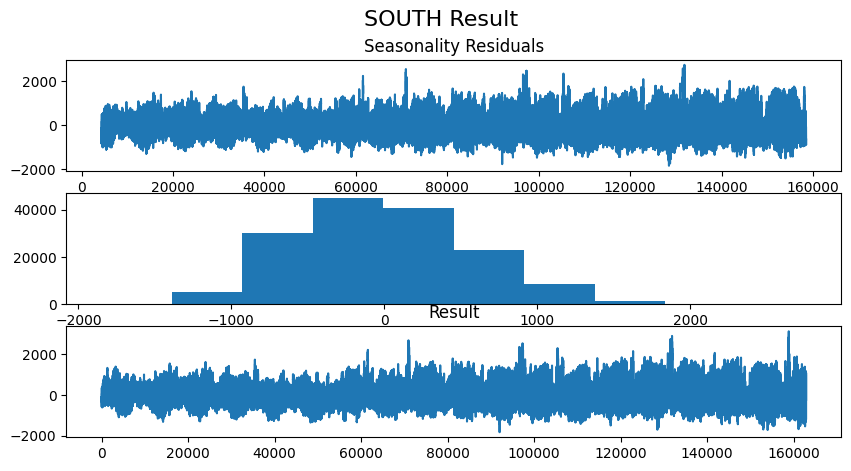

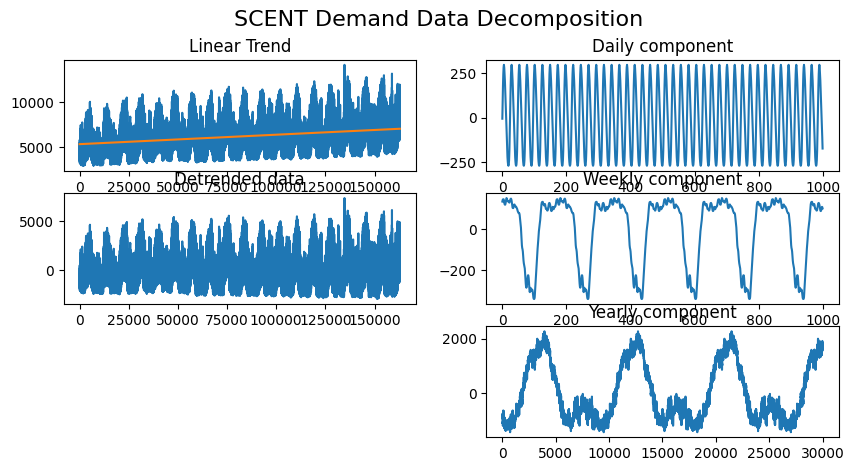

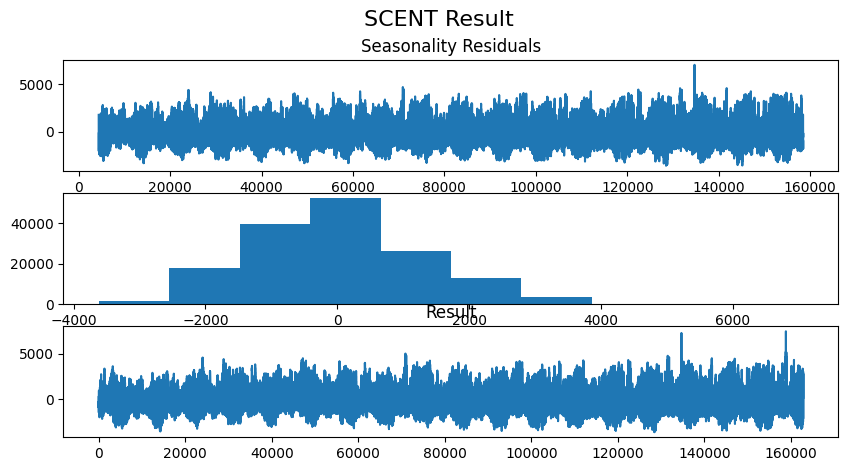

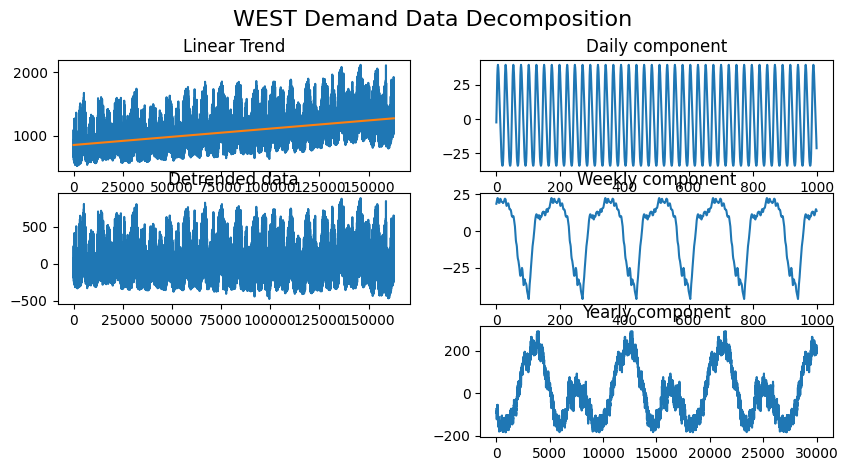

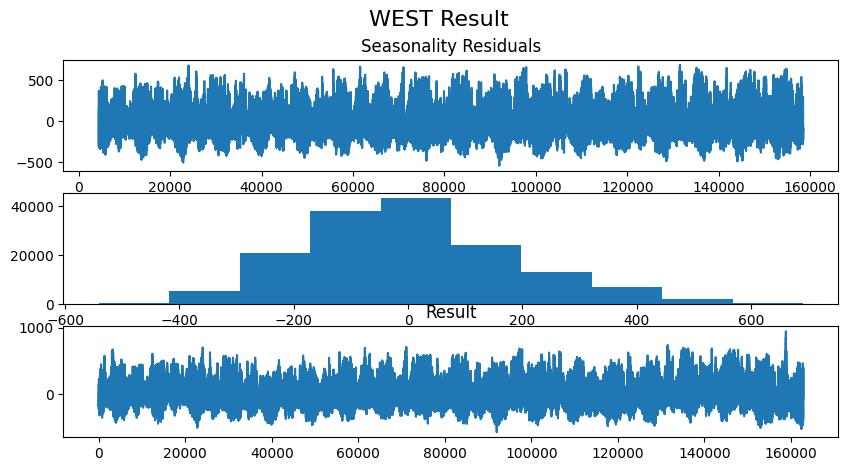

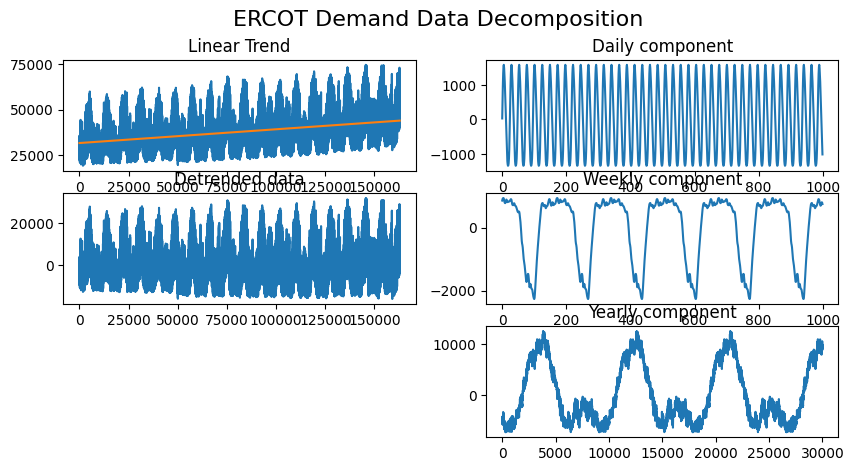

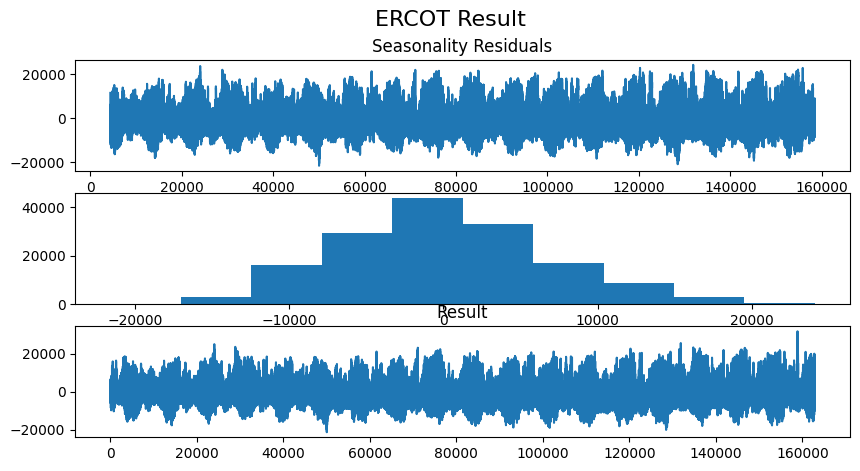

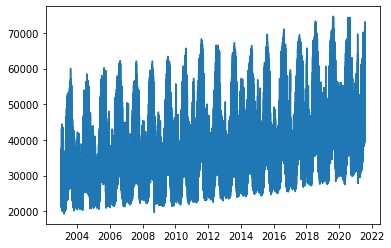

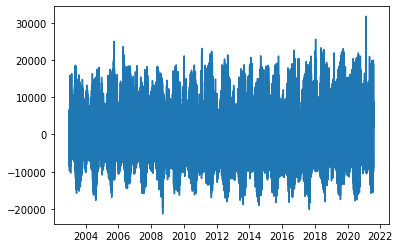

In [ ]:
dblcheckdfs = dfs.dropna()
dblcheckdfs = dblcheckdfs.reset_index(drop=True)
dblcheckdfs = dblcheckdfs.drop_duplicates(subset=['Hour Ending'])

detrendedfs = pd.DataFrame()#.set_axis(['Hour Ending', 'COAST', 'EAST', 'FWEST', 'NORTH', 'NCENT', 'SOUTH', 'SCENT', 'WEST', 'ERCOT'], axis=1, inplace=False)
energy_seasonal_components = pd.DataFrame(index=dblcheckdfs['Hour Ending'], columns=['COAST', 'EAST', 'FWEST', 'NORTH', 'NCENT', 'SOUTH', 'SCENT', 'WEST', 'ERCOT'])
energy_trend_components = pd.DataFrame(index=dblcheckdfs['Hour Ending'], columns=energy_seasonal_components.columns)

dblcheckdfs['Hour Ending'] = pd.DatetimeIndex(dblcheckdfs['Hour Ending'])

dblcheckdfs = dblcheckdfs.set_index(dblcheckdfs['Hour Ending'])

dfs_stationary = dblcheckdfs.dropna()
plt.close()
for col in COLLABELS:
  if(col!='Hour Ending'):
    fig, axes = plt.subplots(3, 2, figsize=(10,5), dpi=100)

    series = dblcheckdfs[col]
    # fit linear model
    X = [i for i in range(0, len(series))]
    X = np.reshape(X, (len(X), 1))
    y = series.values
    model = LinearRegression()
    model.fit(X, y)
    # calculate trend
    trend = model.predict(X)
    # plot trend
    plt.suptitle(col+" Demand Data Decomposition", fontsize=16)
    axes[0][0].plot(y)
    axes[0][0].plot(trend)
    axes[0][0].set_title("Linear Trend")
    # detrend
    detrended = y - trend
    energy_trend_components[col] = trend
    # plot detrended
    axes[1][0].plot(detrended)
    axes[1][0].set_title("Detrended data")
    # empty plots
    axes[2][0].axis('off')

    daily_components = sm.tsa.seasonal_decompose(detrended, period=24)
    weekly_components = sm.tsa.seasonal_decompose(detrended - daily_components.seasonal, period=24*7)
    yearly_components = sm.tsa.seasonal_decompose(detrended - weekly_components.seasonal, period=8766)
    energy_seasonal_components[col] = yearly_components.seasonal

    stationary = detrended - yearly_components.seasonal

    detrendedfs[col] = detrended

    # plot seasonality components
    axes[0][1].plot(daily_components.seasonal[:1000])
    axes[0][1].set_title("Daily component")
    axes[1][1].plot(weekly_components.seasonal[:1000])
    axes[1][1].set_title("Weekly component")
    axes[2][1].plot(yearly_components.seasonal[-30000:])
    axes[2][1].set_title("Yearly component")
    plt.show()

    # show results
    fig, axes = plt.subplots(3, 1, figsize=(10,5), dpi=100)
    plt.suptitle(col+" Result", fontsize=16)
    axes[0].plot(yearly_components.resid)
    axes[0].set_title("Seasonality Residuals")
    axes[1].hist(yearly_components.resid)
    axes[2].plot(stationary)
    axes[2].set_title("Result")
    plt.show()

    #save stationary data
    dfs_stationary[col] = stationary
plt.plot(dblcheckdfs['ERCOT'])
plt.show()
plt.plot(dfs_stationary['ERCOT'])
plt.show()

Below code displays a histogram of the Energy Demand, which allows us to see the data's distribution. As you can see, it is quite significantly positively skewed, or skewed right. This indicates that we may have to perform some sort of Gaussian Transform in order to normalize the data. Note, however, that this data distribution makes logical sense because energy demand generally follows a daily curve with a rough baseline and a few peak hours.

A further note: You may see that the data for Far West Texas not only lacks a skew right, it seems somewhat skewed left. However, we suspect that this is due to outliers. If they were to be removed, this would return the data to a skew right. We will look into whether that data needs to be truncated or removed. 

[[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff26679ae90>]]
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff26d940d90>]]
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff265105650>]]
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff26694b590>]]
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff26694bd90>]]
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff266981650>]]
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff26671b850>]]
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff26cce4590>]]
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff26958d5d0>]]


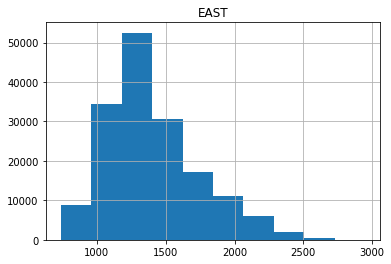

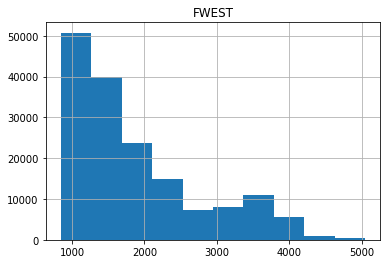

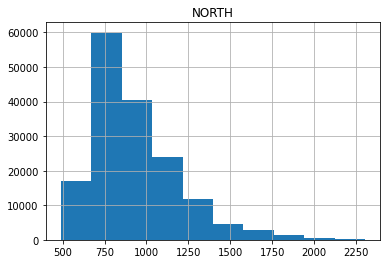

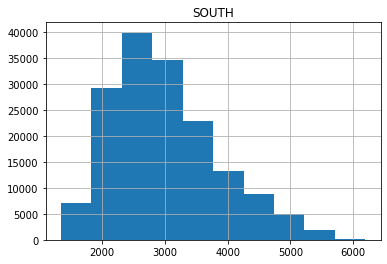

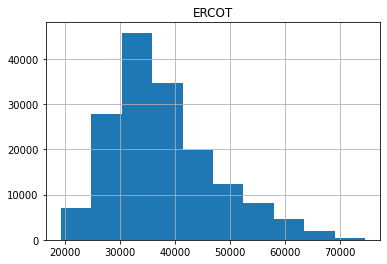

In [ ]:
for col in dfs.columns:
  if(col!="Hour Ending"):
    print(dfs.hist(column=col))

Plots the total energy demand over time and the energy demand in each region over time for 2021

Now, this has been updated to plot the data since 2003. Something very interesting is that the energy consumed by the NORTH region has significantly declined. Conversely, we can see the FWEST region has experienced rapid growth (relatively speaking) in its demand.

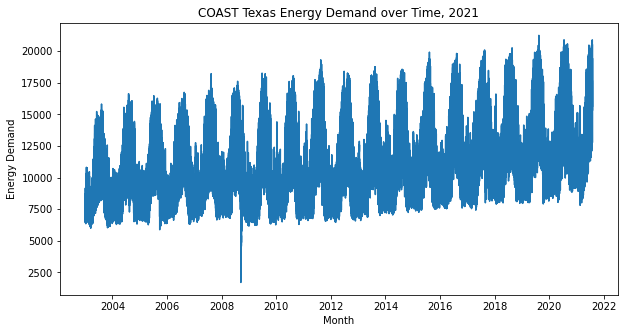

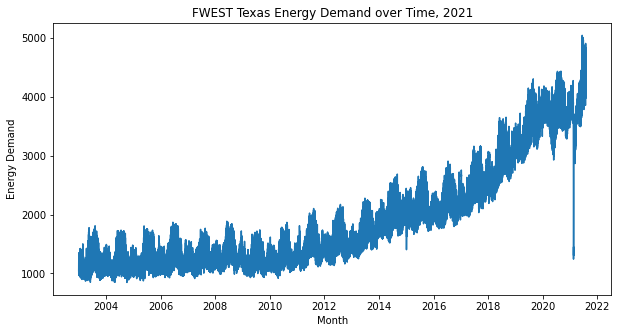

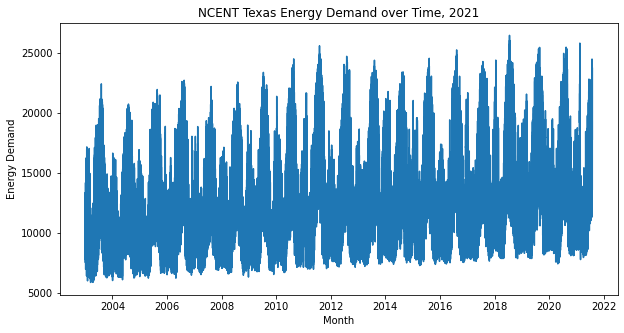

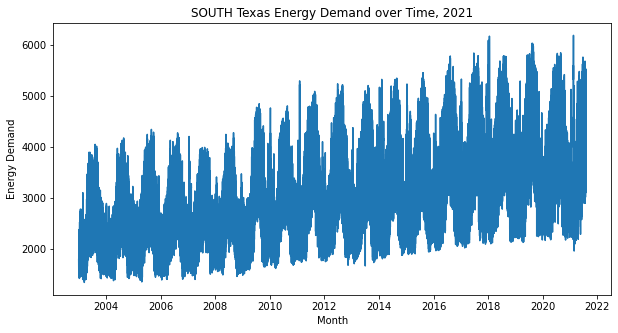

In [ ]:
for col in dfs.columns:
  fig = plt.figure(figsize=(10,5))
  plt.title(col + ' Texas Energy Demand over Time, 2021')
  plt.ylabel('Energy Demand')
  plt.xlabel('Month')
  if(col != 'Hour Ending'):
    plt.plot(dfs['Hour Ending'], dfs[col])
    plt.show()
  plt.close(fig)

The below time plots show the energy demand for a given hour everyday. Ie, the first graph shows the total ERCOT demand at 0:00 (12:00 am) everyday since the start of 2021. An interesting thing to note is how the energy demand increases in the middle hours of the day during the summer months. 

Since we updated the data to include all the weather data since 2003, these graphs have also been updated. You can still see summer peaks, but now, it is because the amplitude of the graph increases later in the day compared to earlier. This is because the relative difference in energy consumed is much greater at later hours in the summer compared to those same hours in the fall, spring, and winter.

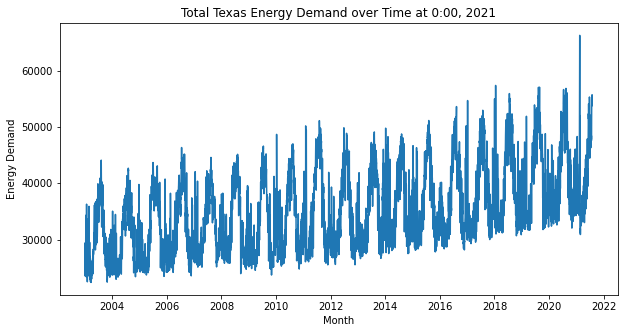

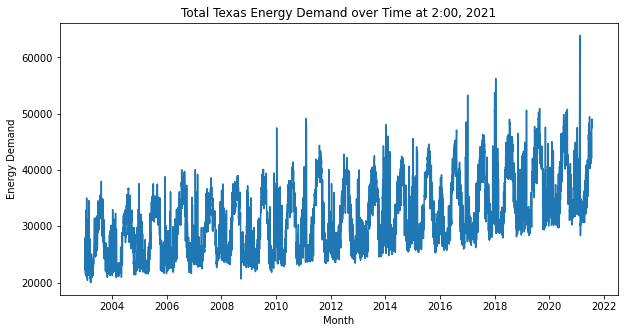

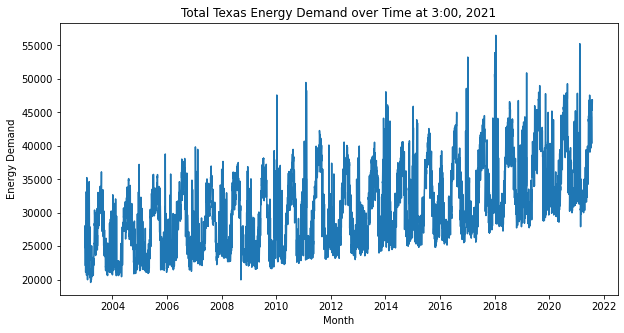

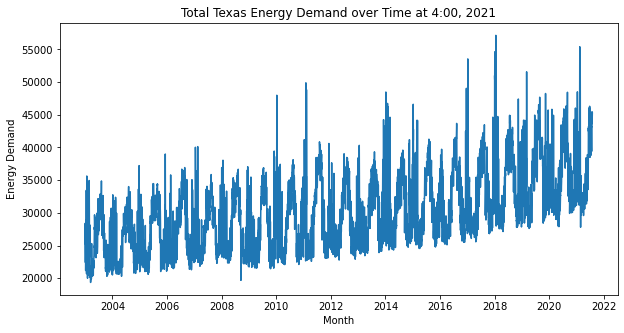

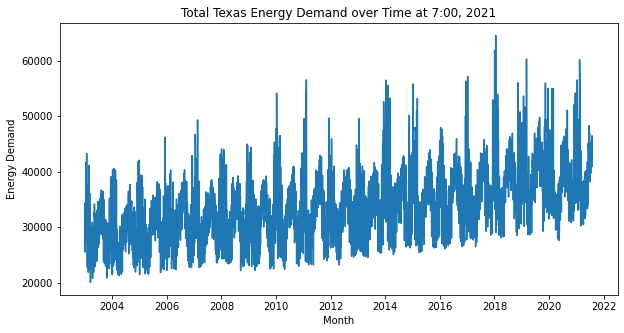

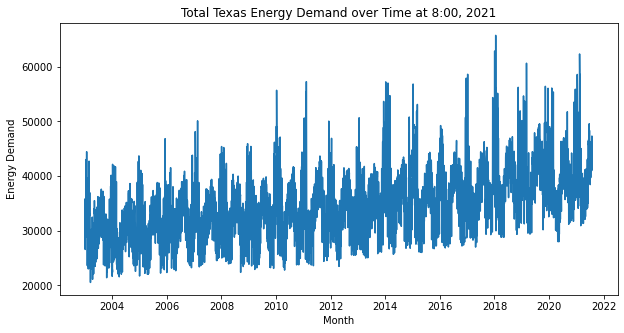

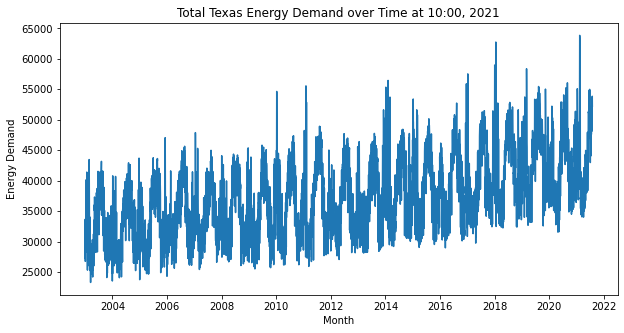

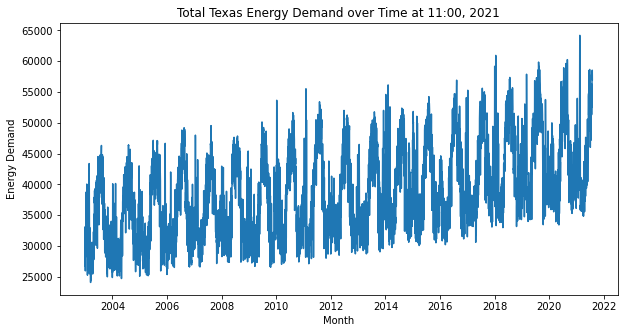

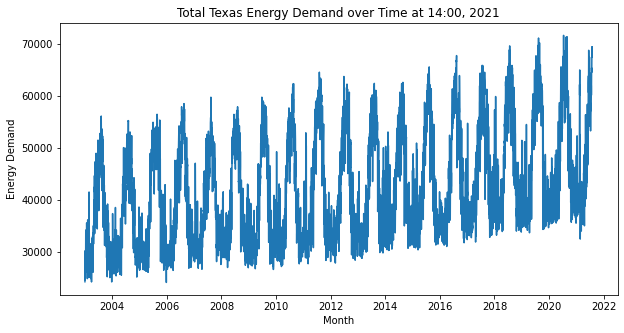

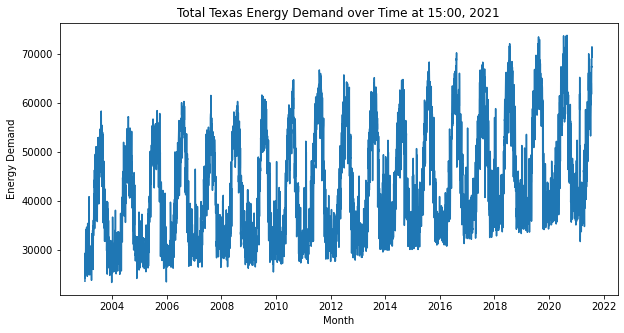

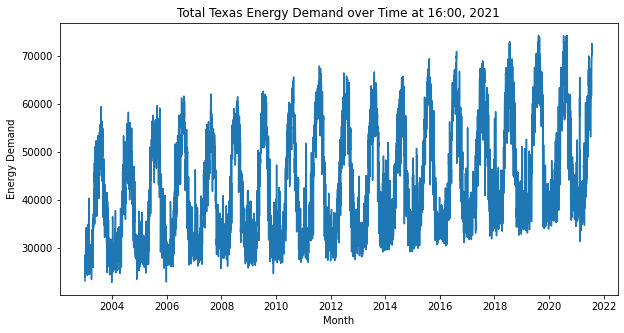

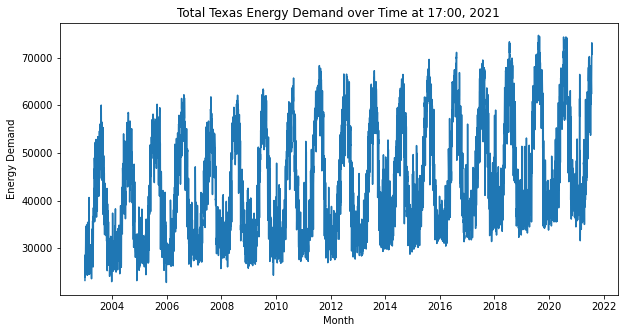

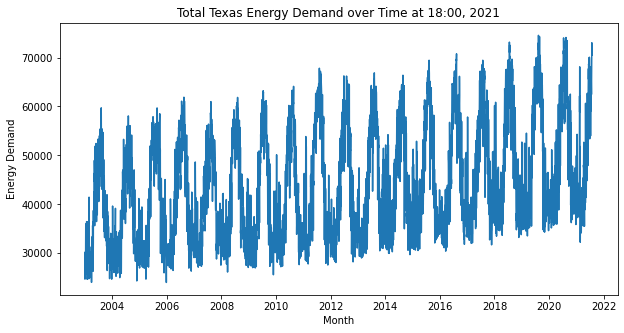

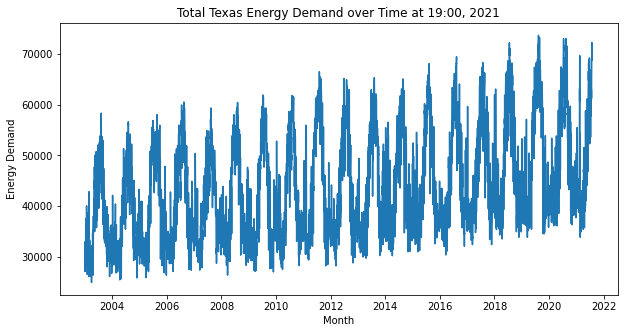

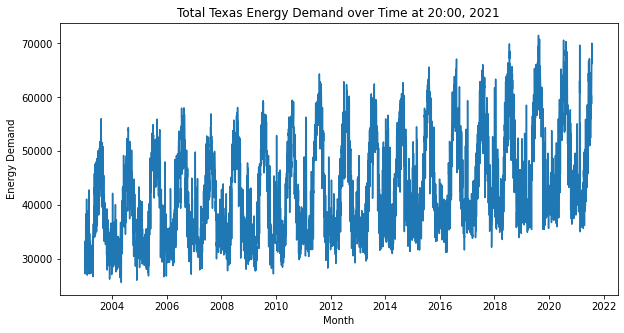

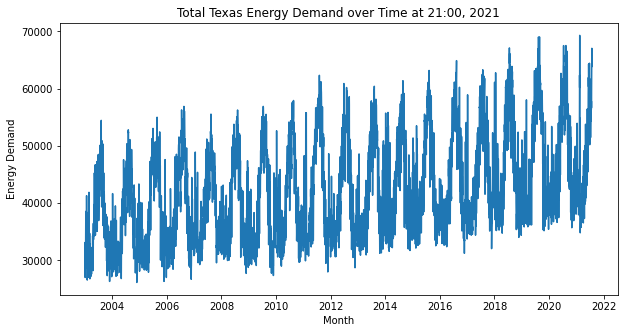

In [ ]:
for hour in list(range(0, 24)):
  fig = plt.figure(figsize=(10,5))
  title = 'Total Texas Energy Demand over Time at ' + str(hour) + ':00' + ', 2021'
  dtHour = dfs[dfs['Hour Ending'].dt.hour == hour]
  plt.title(title)
  plt.ylabel('Energy Demand')
  plt.xlabel('Month')
  plt.plot(dtHour['Hour Ending'], dtHour['ERCOT'])
  plt.show()
  plt.close(fig)
  dtHour.head()

Henceforth, we deal with the weather data

Below code cleans the .csv for each city, and then plots it over time for later analysis. Something interesting you can see is that some cities appear to have experienced a temperature dip, perhaps due to a cold front or something?

It should be noted that this data has been updated since last week to include the weather in the mentioned cities since 2009. Code that is now in ''' comments was used to read, append, and output all that data into single files for each city.

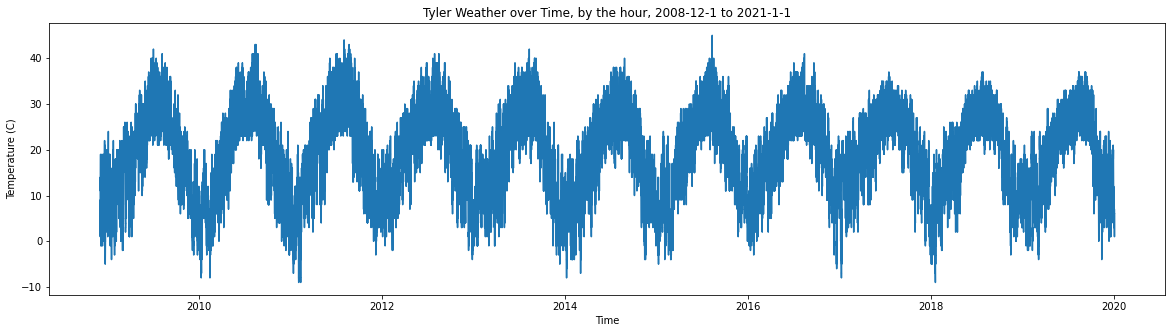

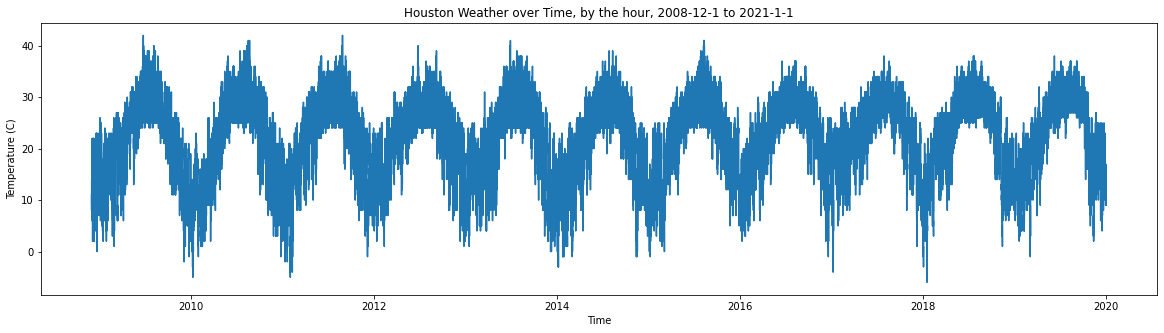

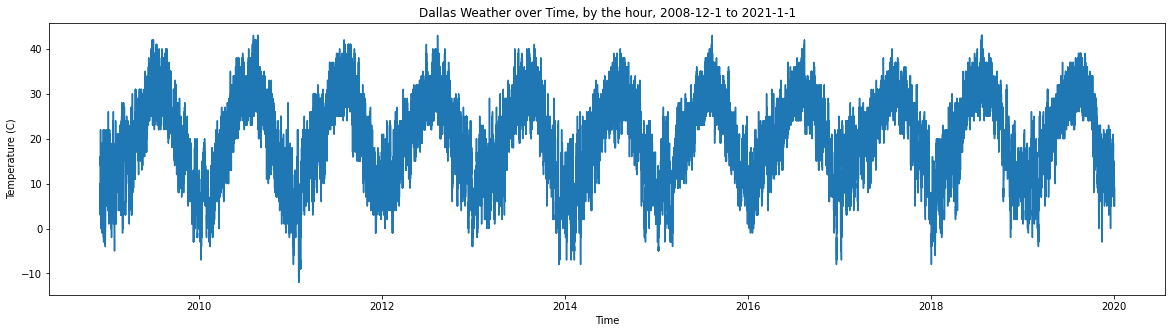

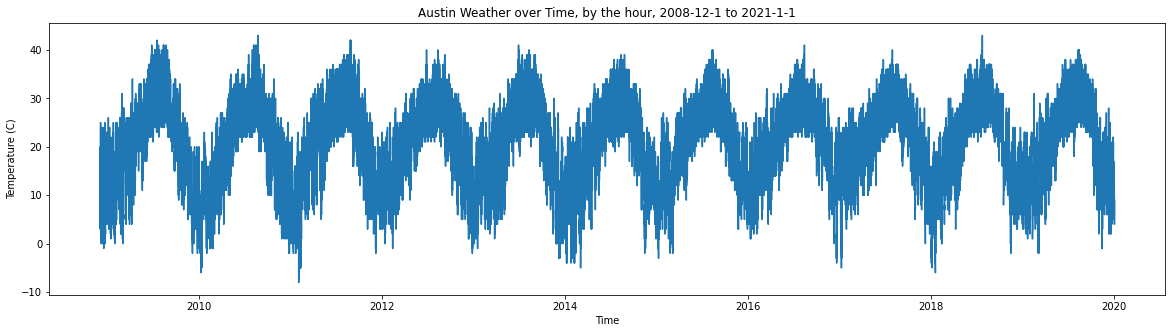

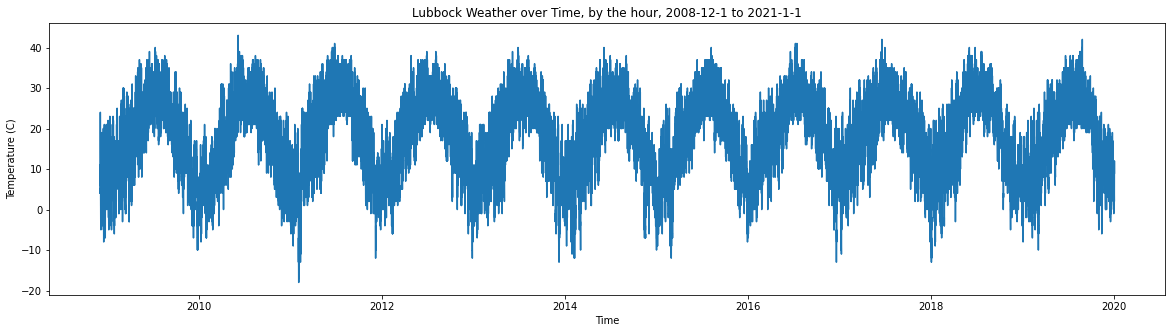

In [ ]:
CITIES = ["Midland", "Abilene", "Tyler", "Houston", "Dallas", "Austin", "Lubbock", "CorpusChristi"]
allCityTemps = pd.DataFrame()
for city in CITIES:
  temps = pd.read_excel("/content/drive/MyDrive/FRI-Group_3/ExtraTempFolder/" + city + "TotalWeatherData.xlsx")
  temps = temps.drop_duplicates(subset=['time'])
  allCityTemps[city] = temps['tempC']

  fig = plt.figure(figsize=(20,5))
  plt.title(city + ' Weather over Time, by the hour, 2008-12-1 to 2021-1-1')
  plt.ylabel('Temperature (C)')
  plt.xlabel('Time')
  #plt.plot(tempdates, temps['tempC'])
  plt.plot(temps['time'], temps['tempC'])
  plt.show()
  plt.close(fig)
allCityTemps['Hour Ending'] = temps['time']

A comparison of each city's weather data and its respective ERCOT region. First is a scatter plot, followed by a graph of its rolling correlation coefficient. Something very interesting is the fact that you can see the correlation between weather and energy demand: weather that strays far from the mean tends to correlate with higher energy demand, which is expected given what we know about how populations tend to consume more power when its colder or warmer than usual. Something quite odd though is the fact that the FWEST region seems to have very little correlation. We are not quite sure what is going on with the FWEST region at this time though.

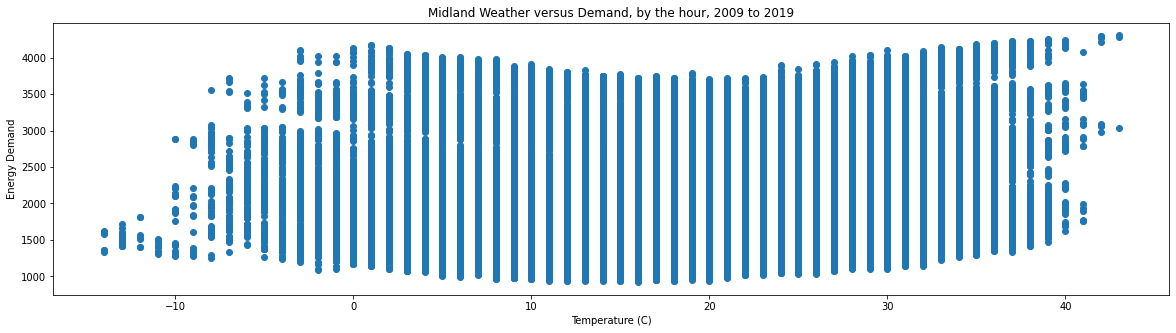

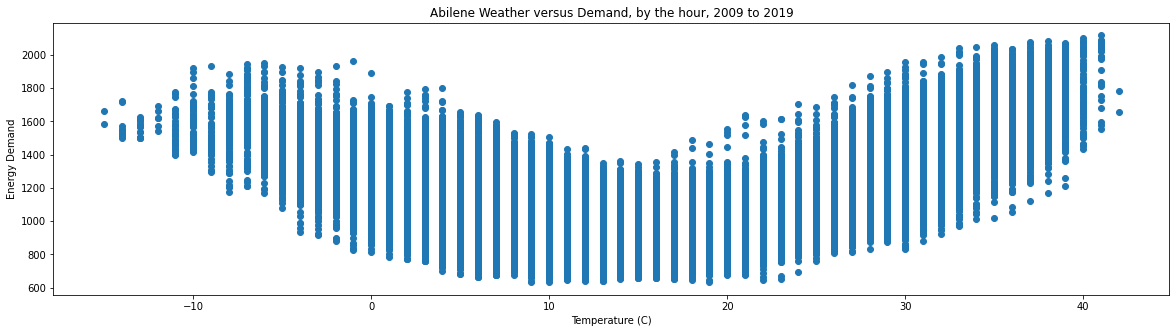

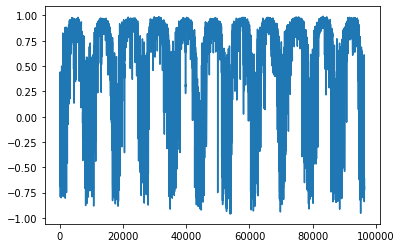

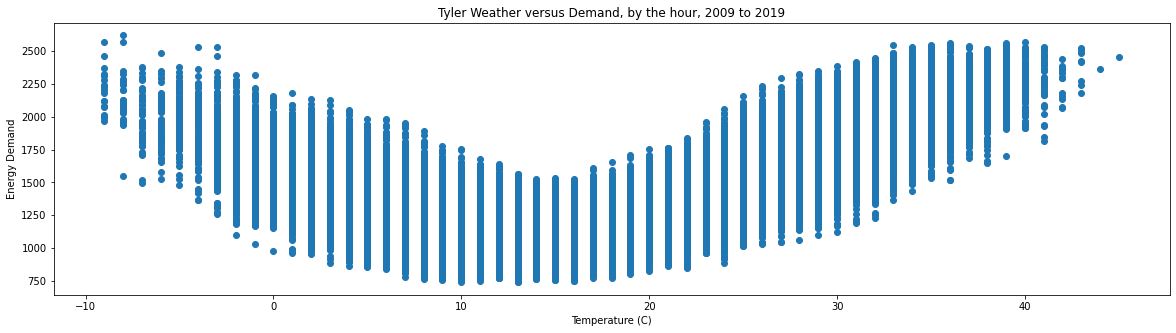

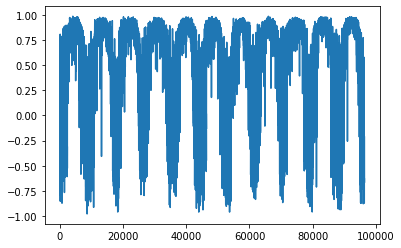

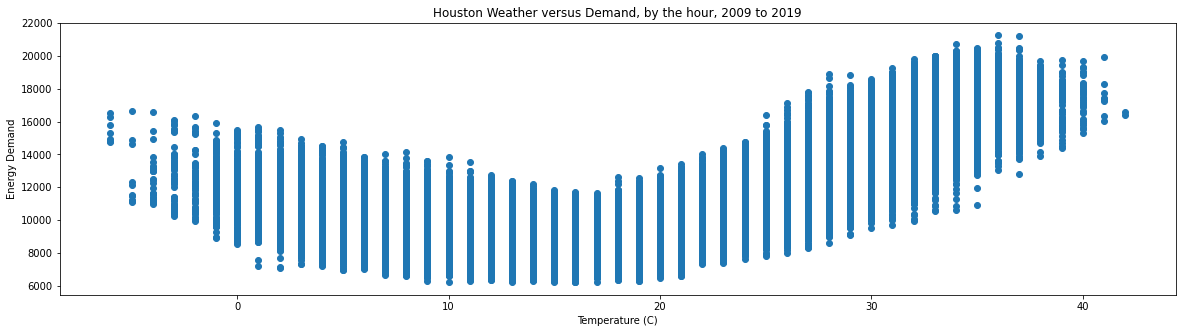

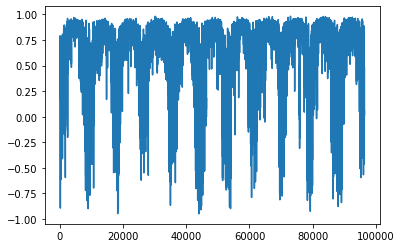

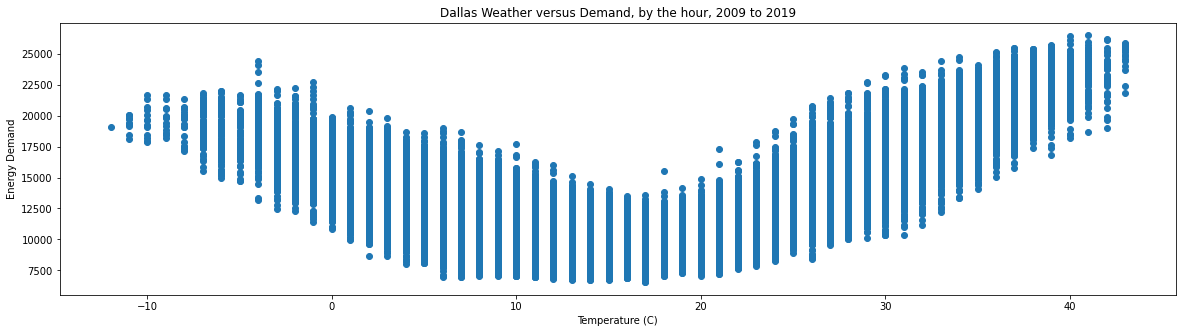

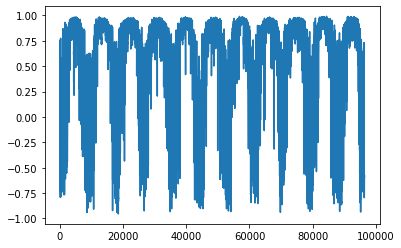

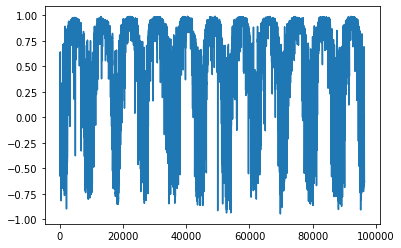

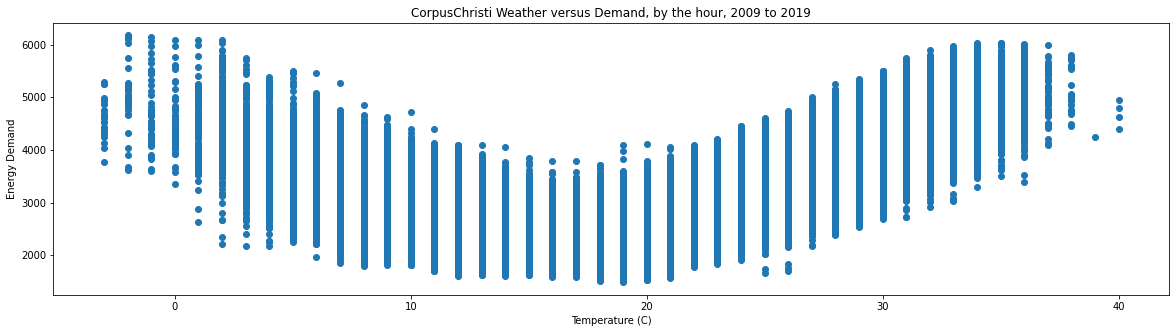

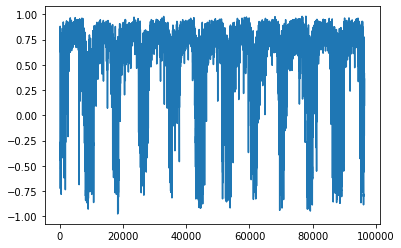

In [ ]:
CityRegionMap = [ ['Midland', 'FWEST'], ['Abilene', 'WEST'], ["Tyler", "EAST"], ["Houston", "COAST"], ["Dallas", "NCENT"], ["Austin", "SCENT"], ["Lubbock", "NORTH"], ["CorpusChristi", "SOUTH"]]

newdfs = dfs[dfs['Hour Ending'].dt.year > 2008]
newdfs = newdfs[newdfs['Hour Ending'].dt.year < 2020]
temperature_dfs = pd.DataFrame(dfs['Hour Ending'])
temperature_dfs = temperature_dfs[temperature_dfs >= datetime.datetime(2008, 12, 1)]
temperature_dfs = temperature_dfs[temperature_dfs <= datetime.datetime(2020, 1, 1)]
for cityMap in CityRegionMap:
  temps = pd.read_excel("/content/drive/MyDrive/FRI-Group_3/ExtraTempFolder/" + cityMap[0] + "TotalWeatherData.xlsx")
  temps = temps.drop_duplicates(subset=['time'])
  newtemps = temps[temps['time'].dt.year > 2008]
  newtemps = newtemps[newtemps['time'].dt.year < 2020]
  
  fig = plt.figure(figsize=(20,5))
  plt.title(cityMap[0] + ' Weather versus Demand, by the hour, 2009 to 2019')
  plt.xlabel('Temperature (C)')
  plt.ylabel('Energy Demand')
  plt.scatter(newtemps['tempC'], newdfs[cityMap[1]])
  plt.show()
  plt.close(fig)
  #pairedvals = pd.DataFrame()
  #pairedvals = pairedvals.append(newtemps['tempC'])
  s1 = newdfs[cityMap[1]]
  s2 = newtemps['tempC']
  temperature_dfs[cityMap[1] + 'TEMP'] = s2
  s1 = s1.reset_index(drop=True)
  s2 = s2.reset_index(drop=True)
  pairedvals = pd.concat([s1, s2], axis=1, ignore_index=True)
  #pairedvals.plot()
  #print(pairedvals.rolling(7).corr(pairwise=True))
  pairedvals[0].rolling(window=30,center=True).corr(pairedvals[1]).plot()



ARIMA model

In [ ]:
!pip3 install pyramid-arima

     |████████████████████████████████| 515 kB 8.7 MB/s 
  ERROR: Failed building wheel for pyramid-arima
  Running setup.py clean for pyramid-arima
Failed to build pyramid-arima
    Running setup.py install for pyramid-arima ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-1pltkg_p/pyramid-arima_8580d13d2ec440af8cf382101976bc34/setup.py'"'"'; __file__='"'"'/tmp/pip-install-1pltkg_p/pyramid-arima_8580d13d2ec440af8cf382101976bc34/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-twy9haic/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7/pyramid-arima Check the logs f

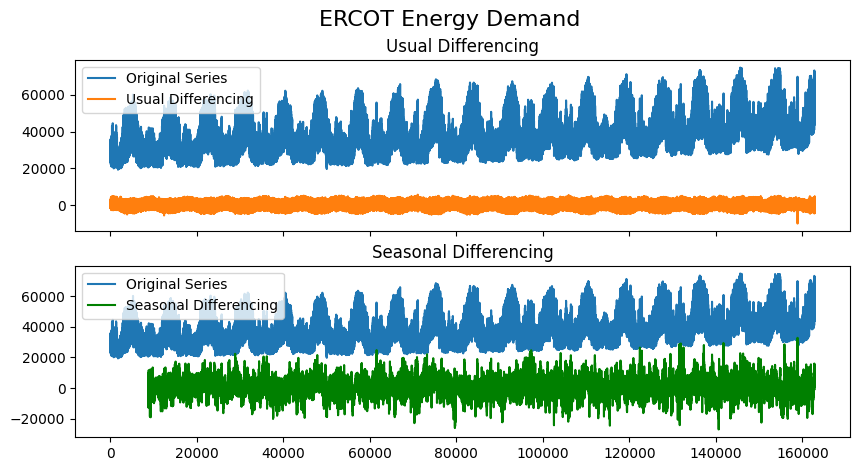

In [ ]:
# Import
data = dfs['ERCOT']


# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(8760), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('ERCOT Energy Demand', fontsize=16)
plt.show()

Split Energy Data into 80% training and 20% testing

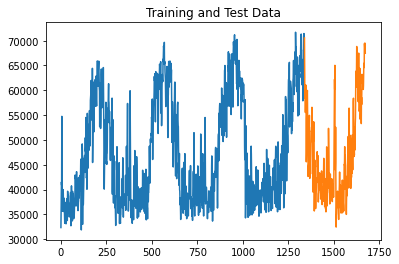

In [ ]:
croppedfs = dfs[dfs['Hour Ending'].dt.year > 2016]
croppedfs = croppedfs[croppedfs['Hour Ending'].dt.hour == 14]
croppedfs = croppedfs.reset_index()
splitNum = int(len(croppedfs) * .8)
energyTrain = croppedfs[:splitNum]
energyTest = croppedfs[splitNum:]
energyTrain = energyTrain.dropna()
energyTrain = energyTrain.reset_index()
energyTrain.shape
energyTest.shape
plt.plot(energyTrain['ERCOT'])
plt.plot(energyTest['ERCOT'])
plt.title("Training and Test Data")
plt.show()
plt.close()

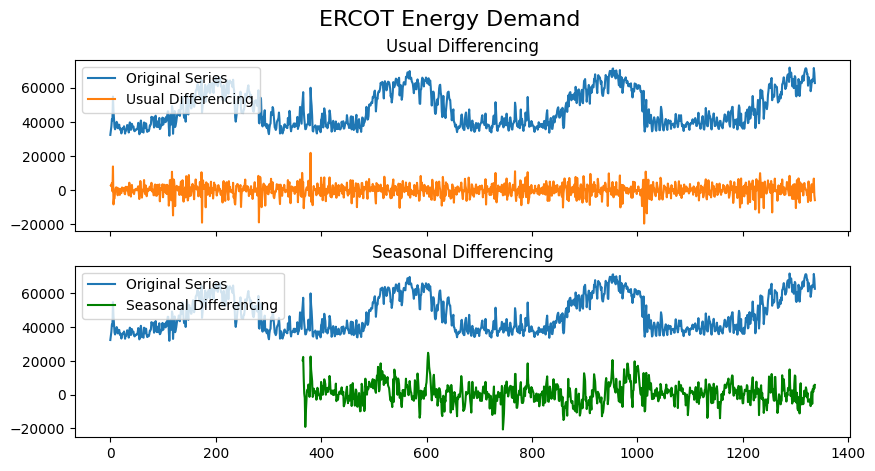

In [ ]:
# Import
data = energyTrain['ERCOT']


# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(365), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('ERCOT Energy Demand', fontsize=16)
plt.show()

SARIMA Model Hyperparameter tuning
Taken from https://stackoverflow.com/questions/56192723how-to-automate-sarima-model-for-time-series-forecasting
(temporary)
WIP: runs out of memory, crashes, ruins everything

https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/

ARIMA Model code is source from Dr. Michael Pyrcz and from https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
#import pmdarima as pm

df = dfs[['Hour Ending', 'ERCOT']].dropna()
df['ERCOT'] = df['ERCOT'].dropna()


splitNum = int(len(df) * .7)
ARIMATrain = df[:splitNum]
ARIMATest = df[splitNum:]

model = pm.auto_arima(ARIMATrain['ERCOT'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1913386.818, Time=16.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2722464.555, Time=1.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=1.32 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2566918.949, Time=18.61 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1847123.639, Time=7.85 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1871741.044, Time=2.24 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1846976.625, Time=48.62 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=2.60 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=1846964.224, Time=36.70 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=3.08 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=1821710.499, Time=82.94 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=6.16 sec
 ARIMA(6,0,1)(0,0,0)[0]             : AIC=1821765.374, Time=104.28 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=1842487.680, Time=115.62 sec
 ARIMA(4,0,2)(

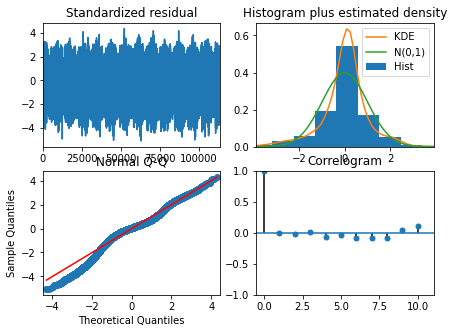

In [ ]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

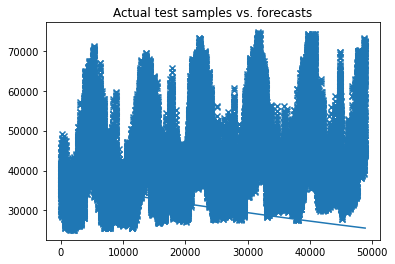

In [ ]:
x = np.arange(ARIMATest['ERCOT'].shape[0])
plt.scatter(x, ARIMATest['ERCOT'], marker='x')
plt.plot(x, model.predict(n_periods=ARIMATest['ERCOT'].shape[0]))
plt.title('Actual test samples vs. forecasts')
plt.show()

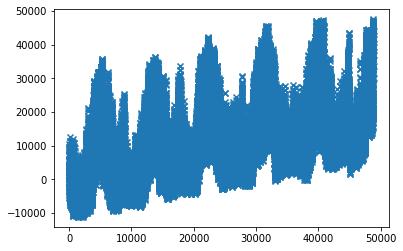

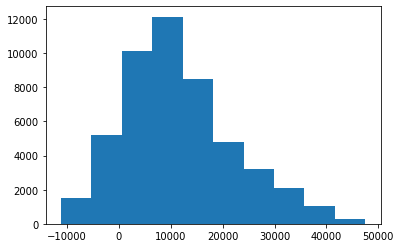

In [ ]:
plt.scatter(x, ARIMATest['ERCOT'] - model.predict(n_periods=ARIMATest['ERCOT'].shape[0]), marker='x')
plt.show()
plt.close()
plt.hist(ARIMATest['ERCOT'] - model.predict(n_periods=ARIMATest['ERCOT'].shape[0]))
plt.show()
#plt.plot(x, model.predict(n_periods=ARIMATest['ERCOT'].shape[0]))

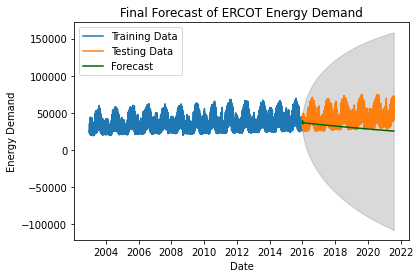

In [ ]:
# Forecast
n_periods = len(ARIMATest)
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
#index_of_fc = np.arange(len(ARIMATrain['ERCOT']), len(ARIMATrain['ERCOT'])+n_periods)
ARIMATrain.index = pd.DatetimeIndex(ARIMATrain['Hour Ending'])
ARIMATest.index = pd.DatetimeIndex(ARIMATest['Hour Ending'])
index_of_fc = ARIMATest.index

tempdf = ARIMATrain[ARIMATrain['Hour Ending'].dt.year > 2012]
# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(ARIMATrain['ERCOT'], label='Training Data')
plt.plot(ARIMATest['ERCOT'], label='Testing Data')
plt.plot(fc_series, color='darkgreen', label='Forecast')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Energy Demand')


plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of ERCOT Energy Demand")
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(ARIMATest['ERCOT'], fc_series))
print(rmse)

15712.271763113953


Below is the code for the SARIMA model. It has now been updated to use cumulative monthly data instead, and it is now fully functional!

First, we create the cumulative data

In [ ]:
#Create cumulative data
dfs = dfs.dropna()
cumulativemonthly = pd.Series()
arr = []
x = 0
sum = 0
for year in range(2003, 2021):
  for month in range(1, 13):
    sum = 0
    for val in dfs[((dfs['Hour Ending'].dt.month == month) & (dfs['Hour Ending'].dt.year == year))]['ERCOT'] :
      sum = sum + val
    if(sum > 0):
      arr.append(sum)
      x = x+1

print(str(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


216


In [ ]:
cumulativemonthly = dfs[((dfs['Hour Ending'].dt.hour == 1) & (dfs['Hour Ending'].dt.day == 1) & (dfs['Hour Ending'].dt.year < 2021))]


In [ ]:
tempseries = pd.Series(arr)
tempseries.describe()

count    2.160000e+02
mean     2.753775e+07
std      5.053908e+06
min      1.969621e+07
25%      2.373901e+07
50%      2.674839e+07
75%      3.121313e+07
max      4.186024e+07
dtype: float64

In [ ]:
cumulativemonthly['ERCOT'] = tempseries.values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
cumulativemonthly.describe()

COAST         EAST  ...         WEST         ERCOT
count    216.000000   216.000000  ...   216.000000  2.160000e+02
mean    9435.182556  1198.332667  ...   931.570259  2.753775e+07
std     1716.622884   218.447729  ...   195.748018  5.053908e+06
min     6458.515900   788.305875  ...   570.476173  1.969621e+07
25%     7987.821585  1027.009216  ...   798.828879  2.373901e+07
50%     9246.638987  1157.841997  ...   900.092191  2.674839e+07
75%    10524.429444  1343.652753  ...  1045.522346  3.121313e+07
max    14937.300862  1933.610237  ...  1762.472684  4.186024e+07

[8 rows x 9 columns]

Plot cumulative monthly data

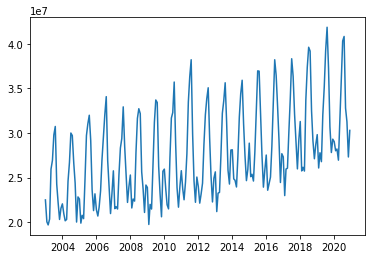

In [ ]:
plt.plot(cumulativemonthly['Hour Ending'], cumulativemonthly['ERCOT'])

Create and fit model using auto_arima to perform grid search

In [ ]:
my_order = (1, 1, 1)
my_seasonal_order = (1, 1, 1, 12)

splitNum = int(len(cumulativemonthly) * .7)
SARIMA_train = cumulativemonthly[:splitNum]
SARIMA_test = cumulativemonthly[splitNum:]

Sarima_model=pm.auto_arima(SARIMA_train['ERCOT'], start_p=1, start_q=1, max_p=8, max_q=8, start_P=1, start_Q=1, max_P=20, max_Q=20, m=12, seasonal=True, trace=True, d=1, D=1, error_action='warn', suppress_warnings=True, random_state = 20, n_fits=30)

Sarima_model.summary()


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=4319.013, Time=1.25 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4341.505, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4328.919, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4324.051, Time=0.26 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=4325.467, Time=0.48 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=4329.339, Time=0.36 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=4320.344, Time=1.26 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=4320.593, Time=2.55 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=4335.740, Time=0.20 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=4319.918, Time=1.77 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=4326.660, Time=0.88 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=inf, Time=4.12 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=4317.307, Time=0.45 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=4327.928, Time=0.17 sec
 ARIMA(0,1,1)(2,1,1)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  151
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2154.654
Date:                            Wed, 01 Dec 2021   AIC                           4317.307
Time:                                    05:39:41   BIC                           4329.016
Sample:                                         0   HQIC                          4322.066
                                            - 151                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1487      0.071     -2.107      0.035      -0.287      -0.010
ar.S.L12       0.4236      0.095      4.462      0.000       0.238       0.610
ma.S.L12      -0.7664      0.120     -6.402      0.000      -1.001      -0.532
sigma2      2.431e+12   1.01e-14   2.42e+26      0.000    2.43e+12    2.43e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.93   Jarque-Bera (JB):                 2.99
Prob(Q):                              0.34   Prob(JB):                         0.22
Heteroskedasticity (H):               0.48   Skew:                            -0.36
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.9e+42. Standard errors may be unstable.
"""

In [ ]:
print(Sarima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  151
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2154.654
Date:                            Wed, 01 Dec 2021   AIC                           4317.307
Time:                                    05:39:41   BIC                           4329.016
Sample:                                         0   HQIC                          4322.066
                                            - 151                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1487      0.071     -2.107      0.035      -0.287      -0.010
ar.S.L12       0.4236      0.095   

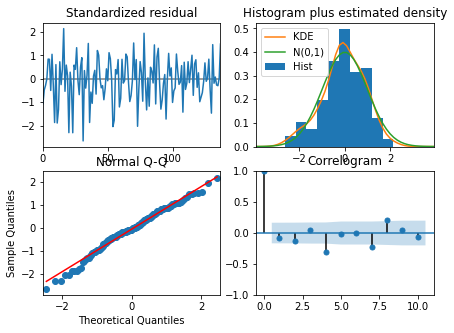

In [ ]:
Sarima_model.plot_diagnostics(figsize=(7,5))
plt.show()

Final forecast below

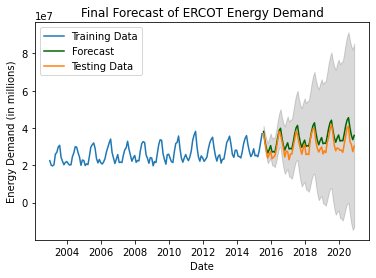

In [ ]:
# Forecast
n_periods = len(SARIMA_test)
fc, confint = Sarima_model.predict(n_periods=n_periods, return_conf_int=True)

SARIMA_train.index = pd.DatetimeIndex(SARIMA_train['Hour Ending'])
SARIMA_test.index = pd.DatetimeIndex(SARIMA_test['Hour Ending'])
index_of_fc = SARIMA_test.index

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

# Plot
plt.plot(SARIMA_train['ERCOT'], Label='Training Data')
plt.plot(fc_series, color='darkgreen', Label='Forecast')
plt.plot(SARIMA_test['ERCOT'], Label='Testing Data')
plt.legend(loc = 'upper left')
plt.title("Final Forecast of ERCOT Energy Demand")
plt.xlabel("Date")
plt.ylabel("Energy Demand (in millions)")
plt.show()

Actual SARIMA Residuals

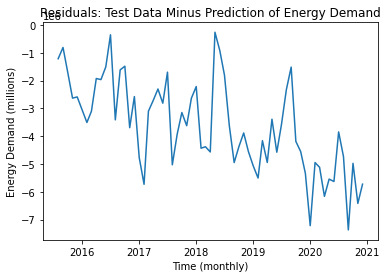

In [ ]:
plt.plot(SARIMA_test['ERCOT'] - fc_series)
plt.title("Residuals: Test Data Minus Prediction of Energy Demand")
plt.xlabel("Time (monthly)")
plt.ylabel("Energy Demand (millions)")
plt.show()

SARIMA RMSE (note: very high value due to the data itself being cumulative)

In [ ]:
rmse = np.sqrt(mean_squared_error(SARIMA_test['ERCOT'], fc_series))
print(rmse)

3977651.411482108


Below, we run the fbprophet model

In [ ]:
#!pip install fbprophet
from fbprophet import Prophet

In [ ]:
ercotdfs = pd.read_excel("/content/drive/MyDrive/FRI-Group_3/EnergyDemandXLSXFiles/ConsolidatedEnergyDemandData.xlsx", sheet_name = 'ERCOT')

In [ ]:
splitNum = int(len(ercotdfs) * .7)

pro_energy_train = ercotdfs[:splitNum]
pro_energy_test = ercotdfs[splitNum:]

m = Prophet()
m.fit(pro_energy_train)
future = m.make_future_dataframe(periods=len(pro_energy_test), freq='h')

Plot the resulting Prophet model.

In [ ]:
forecast = m.predict(future)

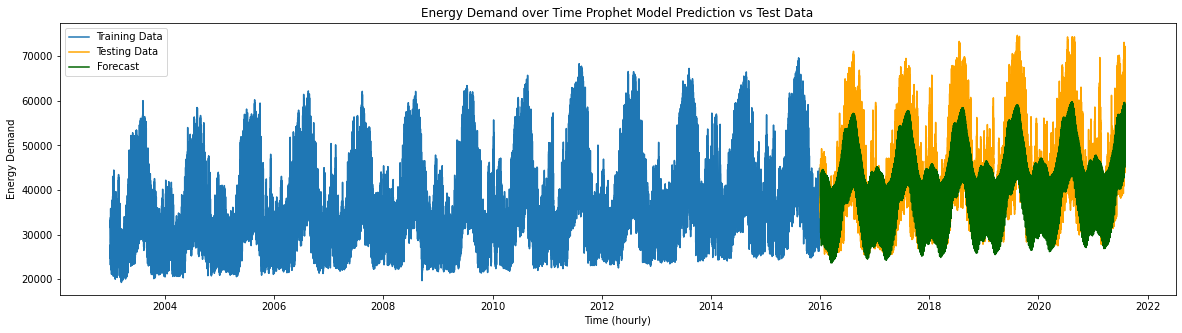

In [ ]:
pro_energy_test.index = pd.DatetimeIndex(pro_energy_test['ds'])
pro_energy_train.index = pd.DatetimeIndex(pro_energy_train['ds'])
forecast.index = pd.DatetimeIndex(forecast['ds'])
plt.close('all')
plt.figure(figsize=(20, 5))
plt.plot(pro_energy_train['y'], Label='Training Data')
plt.plot(pro_energy_test['y'], color='orange', Label='Testing Data')
plt.plot(forecast[splitNum:]['yhat'], color='darkgreen', Label='Forecast')
plt.legend()
plt.xlabel('Time (hourly)')
plt.ylabel('Energy Demand')
plt.title("Energy Demand over Time Prophet Model Prediction vs Test Data")

plt.show()

Below is the RMSE for the prophet univariate

In [ ]:
fdfs = pd.DataFrame()
fdfs['y'] = pro_energy_test['y']
fdfs['yhat'] = forecast['yhat']
fdfs = fdfs.dropna()
rmse = np.sqrt(mean_squared_error(fdfs['y'], fdfs['yhat']))
print(rmse)

5332.767823890657


Prophet residuals plot (actual - predicted)

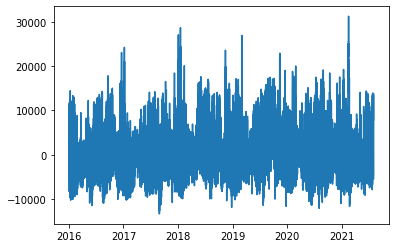

In [ ]:
plt.plot(fdfs['y'] - fdfs['yhat'])

Seasonal components breakdown. Just something interesting to look at

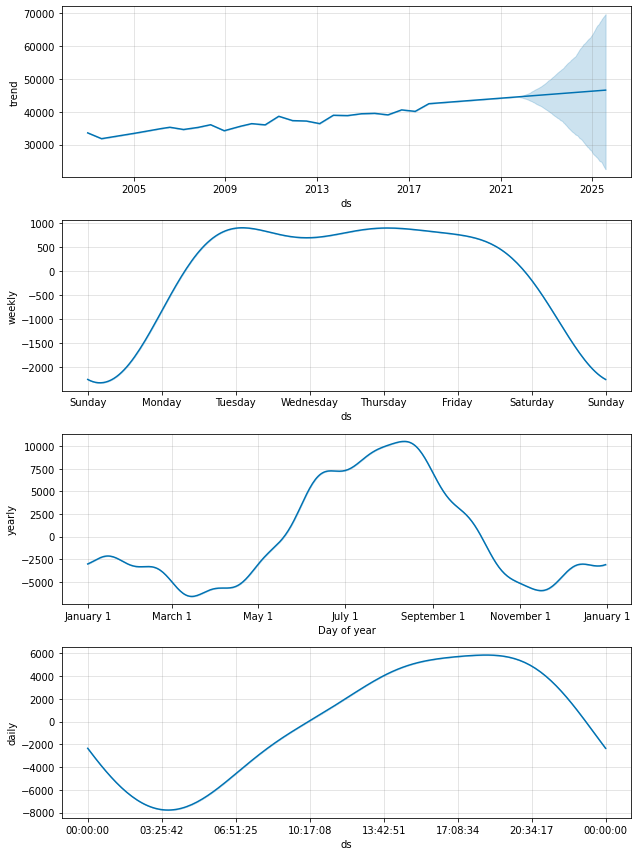

In [ ]:
fig2 = m.plot_components(forecast)

Prophet model for temperature per region

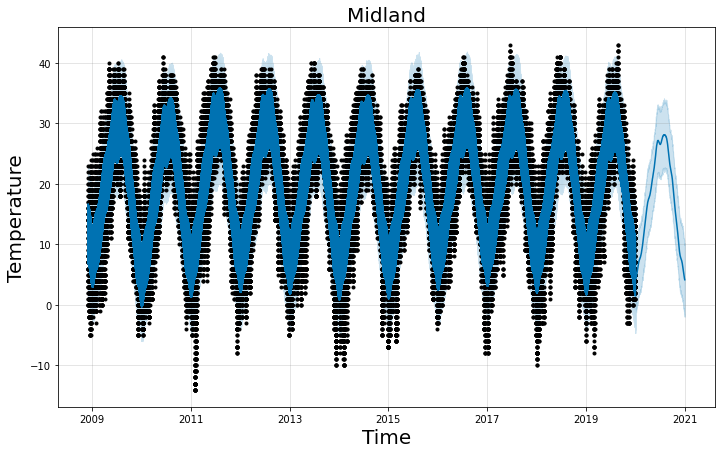

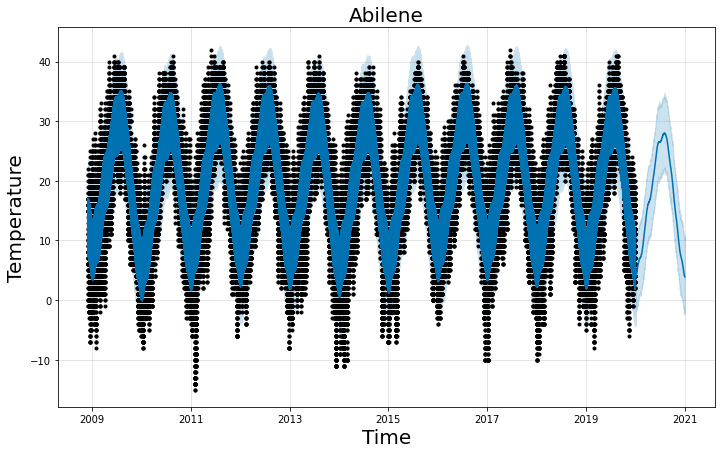

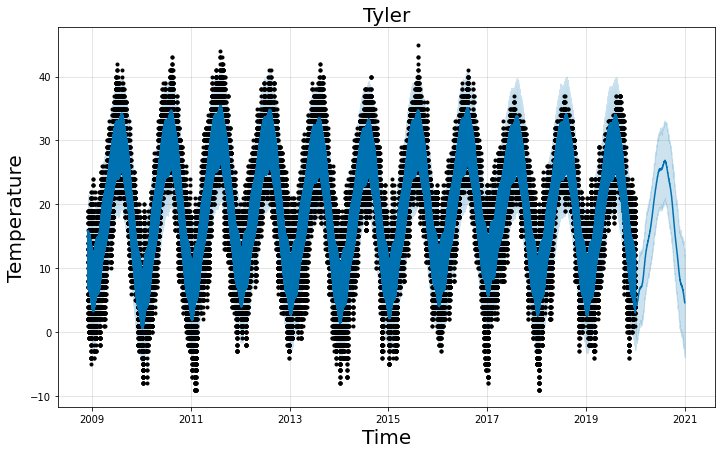

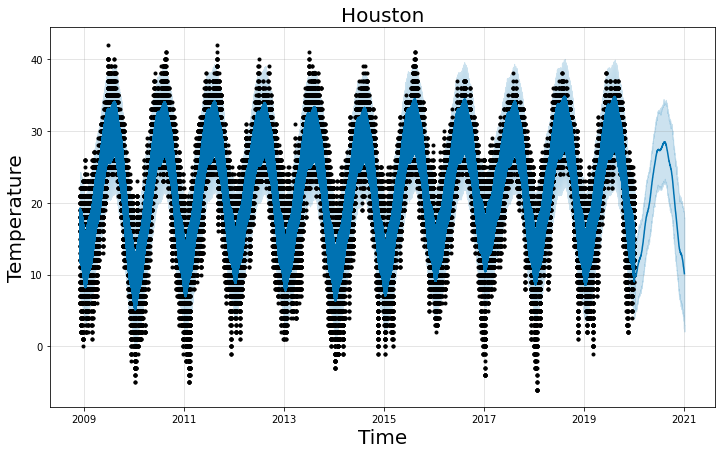

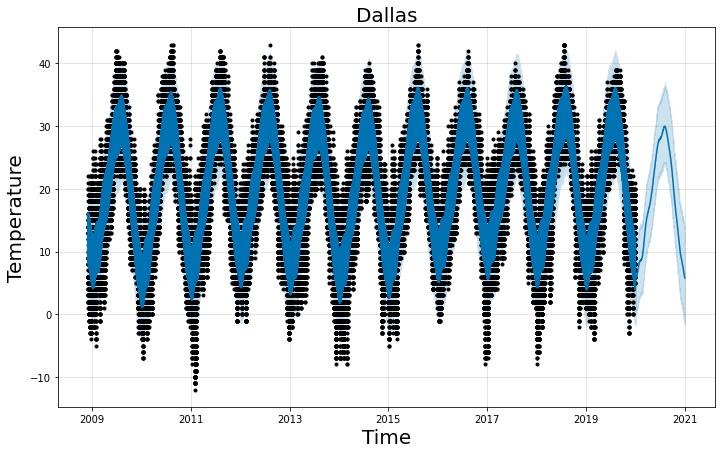

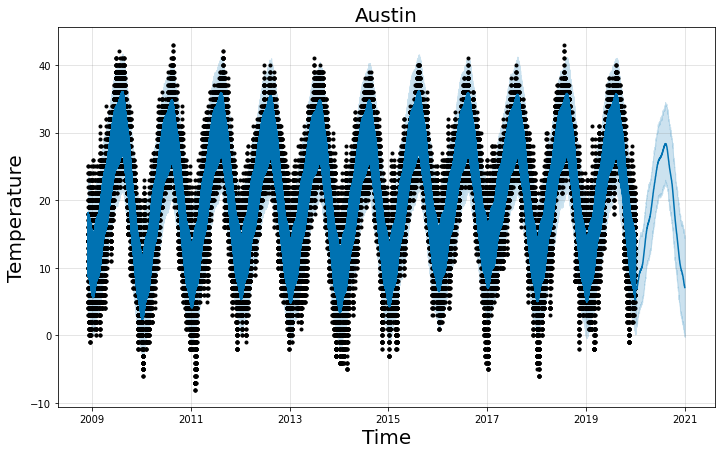

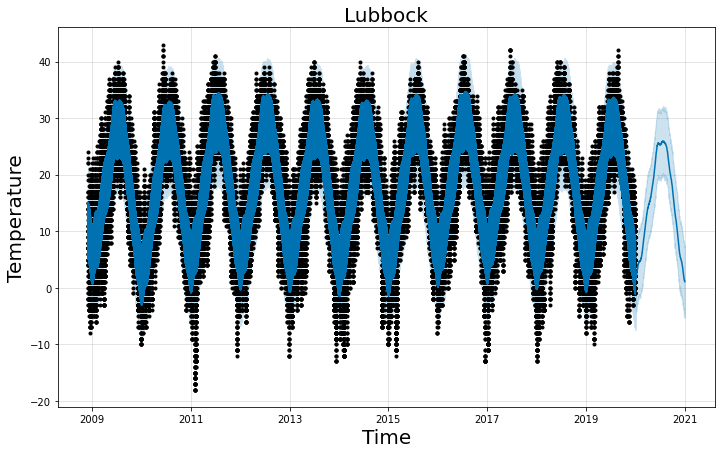

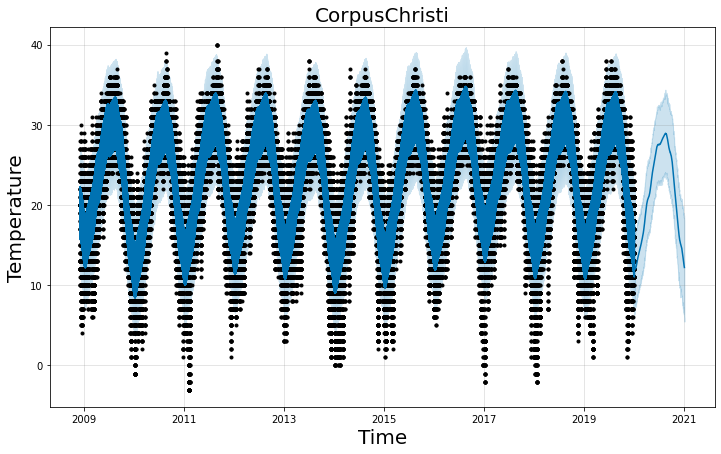

In [ ]:
allCityTemps
for city in allCityTemps.columns:
  if city != 'Hour Ending':
    prophetTemp = pd.DataFrame(columns=['ds','y'])
    prophetTemp['ds'] = allCityTemps['Hour Ending']
    prophetTemp['y'] = allCityTemps[city]
    m = Prophet()
    m.fit(prophetTemp)
    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(future)
    fig1 = m.plot(forecast, xlabel="Time", ylabel="Temperature")
    ax = fig1.gca()
    ax.set_title(city, size=20)
    ax.set_xlabel("Time", size=20)
    ax.set_ylabel("Temperature", size=20)

MultiVariate Prophet on energy demand and temperature.

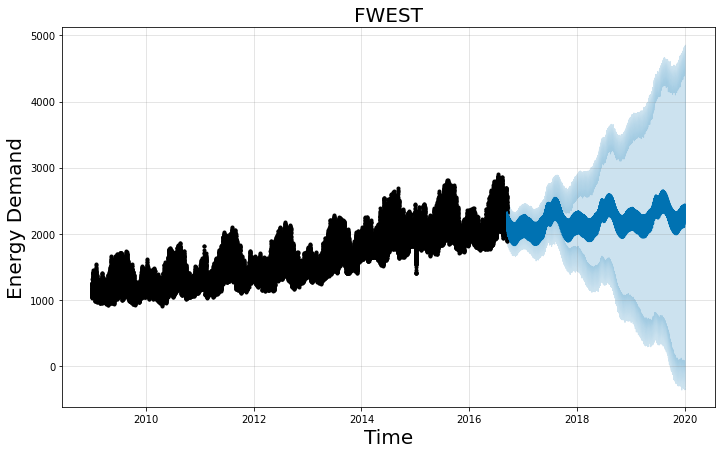

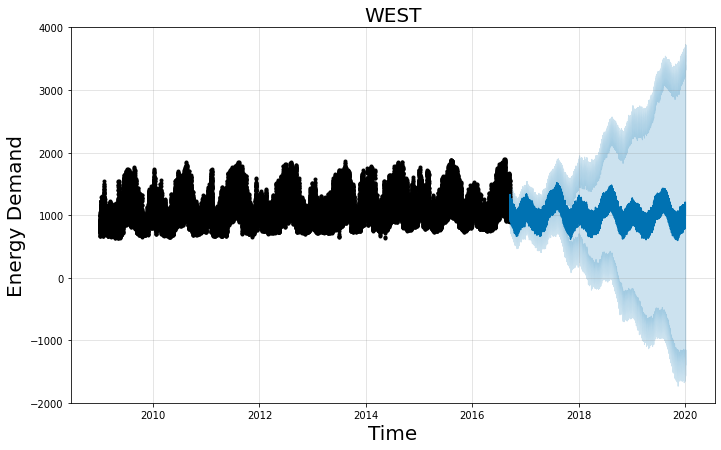

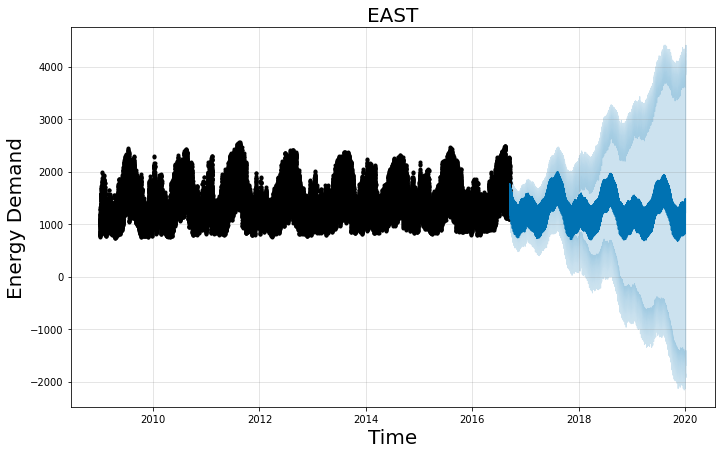

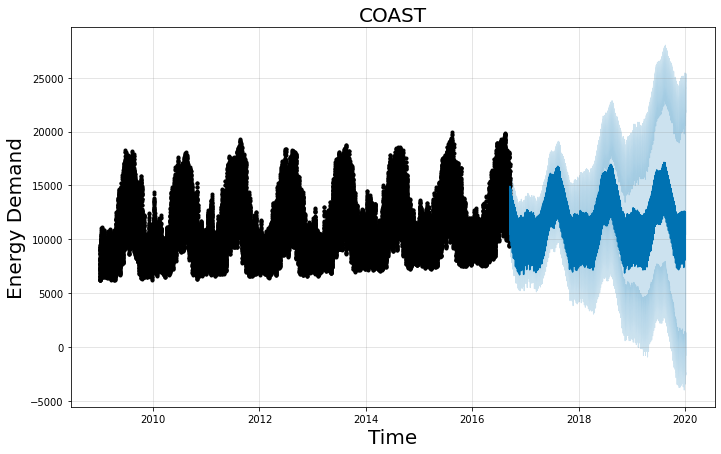

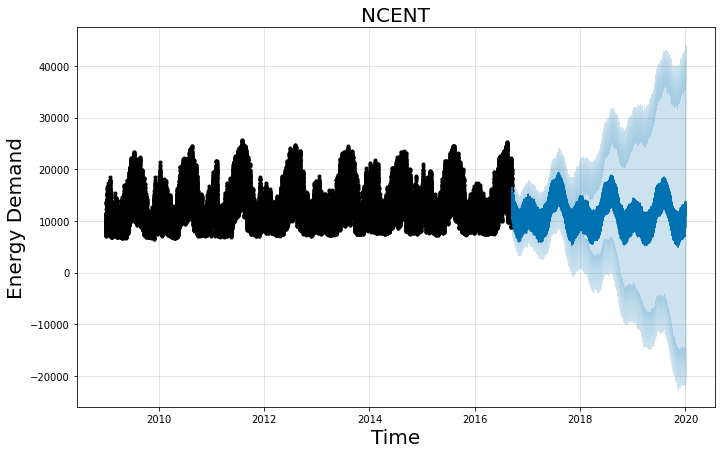

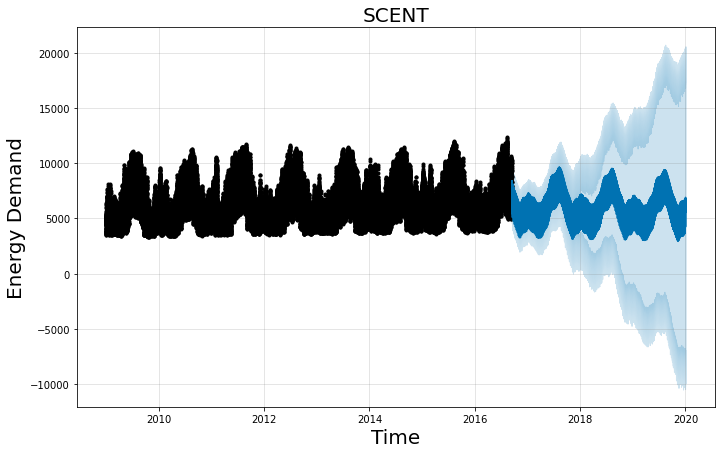

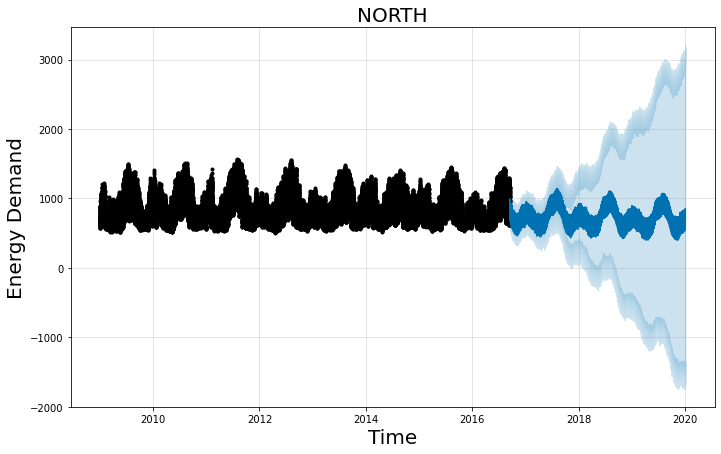

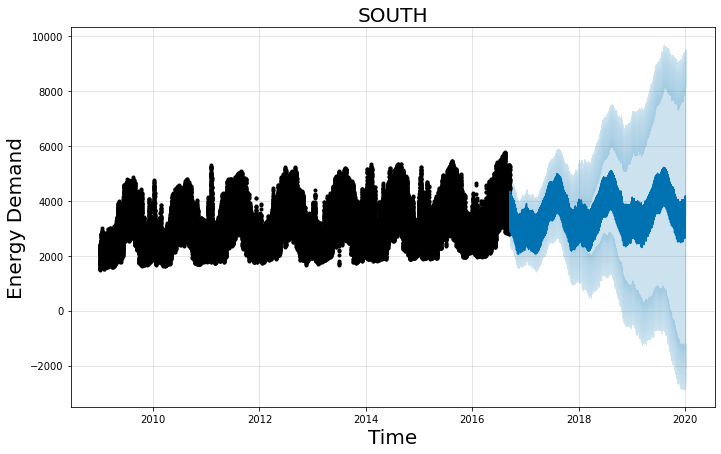

In [ ]:
energy_prophet_dfs = dfs.dropna()
CityRegionMap = [ ['Midland', 'FWEST'], ['Abilene', 'WEST'], ["Tyler", "EAST"], ["Houston", "COAST"], ["Dallas", "NCENT"], ["Austin", "SCENT"], ["Lubbock", "NORTH"], ["CorpusChristi", "SOUTH"]]

regionalForecasts = pd.DataFrame()
totalEnergyTrain = pd.DataFrame()
totalEnergyTest = pd.DataFrame()

for cityMap in CityRegionMap:
  prophetEnergy = pd.DataFrame()
  #Discard data prior to 2009 so that energy and temperature sets are matching
  prophetEnergy['temperature'] = allCityTemps[allCityTemps['Hour Ending'].dt.year > 2008].reset_index()[cityMap[0]]
  prophetEnergy['ds'] = allCityTemps[allCityTemps['Hour Ending'].dt.year > 2008].reset_index()['Hour Ending']
  prophetEnergy['y'] = (dfs[dfs['Hour Ending'].dt.year > 2008]).reset_index()[cityMap[1]]
  prophetEnergy = prophetEnergy.dropna()

  m = Prophet()
  m.add_regressor('temperature')

  #Split data into training and testing set
  splitNum = int(len(prophetEnergy) * .7)
  energyTrain = prophetEnergy[:splitNum]
  totalEnergyTrain[cityMap[1]] = energyTrain['y']
  energyTest = prophetEnergy[splitNum:]
  totalEnergyTest[cityMap[1]] = energyTest['y']
  #Fit data and plot predictions for each region
  m.fit(energyTrain)
  forecast = m.predict(energyTest.drop(columns='y'))
  regionalForecasts[cityMap[1]] = forecast['yhat']
  finalcol = cityMap[1]
  fig1 = m.plot(forecast, xlabel="Time", ylabel="Energy Demand")
  ax = fig1.gca()
  ax.set_title(cityMap[1], size=20)
  ax.set_xlabel("Time", size=20)
  ax.set_ylabel("Energy Demand", size=20)

regionalForecasts['ds'] = forecast['ds']

Below is the plot of the total ERCOT grid prediction, created by summing all of the regions

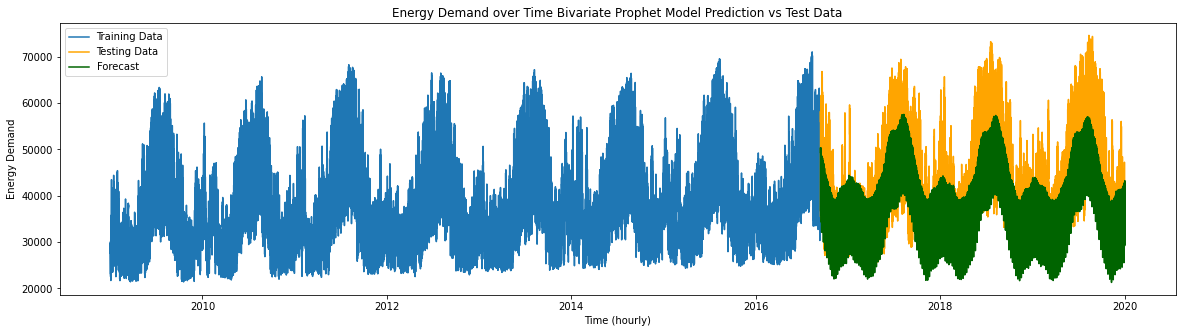

In [ ]:
regionalForecastsWithoutBadStuff = regionalForecasts[['FWEST', 'WEST', 'EAST', 'COAST', 'NCENT', 'SCENT', 'NORTH', 'SOUTH']]
energyTrainWBS = totalEnergyTrain[['FWEST', 'WEST', 'EAST', 'COAST', 'NCENT', 'SCENT', 'NORTH', 'SOUTH']]
energyTestWBS = totalEnergyTest[['FWEST', 'WEST', 'EAST', 'COAST', 'NCENT', 'SCENT', 'NORTH', 'SOUTH']]
#print(regionalForecastsWithoutBadStuff['ds'])
#plt.plot(dfs['ERCOT'])
regionalForecastsWithoutBadStuff.index = pd.DatetimeIndex(regionalForecasts['ds'])
energyTrainWBS.index = pd.DatetimeIndex(energyTrain['ds'])
energyTestWBS.index = pd.DatetimeIndex(energyTest['ds'])

plt.close('all')
plt.figure(figsize=(20, 5))
plt.plot(energyTrainWBS.cumsum(axis = 1, skipna=True)['SOUTH'], Label='Training Data')
plt.plot(energyTestWBS.cumsum(axis = 1, skipna=True)['SOUTH'], color='orange', Label='Testing Data')
plt.plot(regionalForecastsWithoutBadStuff.cumsum(axis = 1, skipna=True)['SOUTH'], color='darkgreen', Label='Forecast')
plt.legend()
plt.xlabel('Time (hourly)')
plt.ylabel('Energy Demand')
plt.title("Energy Demand over Time Bivariate Prophet Model Prediction vs Test Data")


plt.show()

Prophet Bivariate RMSE and Residuals Plot

6418.701539280174


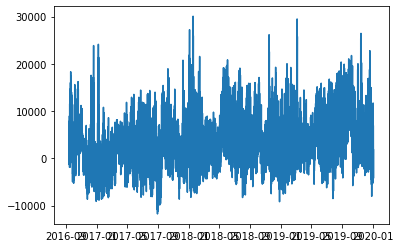

In [ ]:
fwdfs = pd.DataFrame()
fwdfs['y'] = energyTestWBS.cumsum(axis = 1, skipna=True)['SOUTH']
fwdfs['yhat'] = regionalForecastsWithoutBadStuff.cumsum(axis = 1, skipna=True)['SOUTH']
fwdfs = fwdfs.dropna()
rmse = np.sqrt(mean_squared_error(fwdfs['y'], fwdfs['yhat']))
print(rmse)
plt.plot(fwdfs['y']-fwdfs['yhat'])
plt.show()

Below is population analysis of Texas counties and ERCOT regions. Ultimately, we didn't end up using this, but we left this here for reference

In [ ]:
# Read in the county list
l = pd.read_csv("/content/drive/MyDrive/FRI-Group_3/PopulationFiles/countylist.csv")
#print(l)

# Read in population data per county
pop = pd.read_csv("/content/drive/MyDrive/FRI-Group_3/PopulationFiles/2019_txpopest_county.csv", index_col="county")
pop = pop.drop("FIPS", axis=1)

cols = list(l)
zonepop = [0] * 8
idx = 0
for i in cols:
    counties = list(l[i])
    for c in counties:
        if not pd.isna(c):
            zonepop[idx] += pop["jan1_2020_pop_est"][c]
    idx += 1

#ERCOT population per zone
for i in range(8):
    print("Zone", cols[i], ":", zonepop[i])

#Largest county per zone
largest = [""] * 8
largestsize = [0] * 8
idx = 0
for i in cols:
    counties = list(l[i])
    for c in counties:
        if not pd.isna(c):
            if pop["jan1_2020_pop_est"][c] > largestsize[idx]:
                largestsize[idx] = pop["jan1_2020_pop_est"][c]
                largest[idx] = c;
    idx += 1
for i in range(8):
    print("Zone", cols[i], ", Largest county:", largest[i], ", size", largestsize[i])
for i in range(8):
    print("Zone", cols[i], ", Largest county size / region size:", largestsize[i] / zonepop[i])



Zone COAST : 6897227
Zone EAST : 1196869
Zone FWEST : 512764
Zone NORTH : 1204000
Zone NCENT : 8717822
Zone SOUTH : 2463549
Zone SCENT : 5086377
Zone WEST : 589220
Zone COAST , Largest county: Harris , size 4703708
Zone EAST , Largest county: Brazos , size 233071
Zone FWEST , Largest county: Midland , size 179232
Zone NORTH , Largest county: Lubbock , size 309880
Zone NCENT , Largest county: Dallas , size 2647627
Zone SOUTH , Largest county: Hidalgo , size 888958
Zone SCENT , Largest county: Bexar , size 2006193
Zone WEST , Largest county: Taylor , size 139083
Zone COAST , Largest county size / region size: 0.6819708848208128
Zone EAST , Largest county size / region size: 0.19473392660349628
Zone FWEST , Largest county size / region size: 0.3495409194093189
Zone NORTH , Largest county size / region size: 0.25737541528239205
Zone NCENT , Largest county size / region size: 0.30370280558607415
Zone SOUTH , Largest county size / region size: 0.36084445651375313
Zone SCENT , Largest county 

Below is the Vector Auto Regression Models.
First we must check for stationarity.

          FWESTTEMP      WESTTEMP  ...     NORTHTEMP     SOUTHTEMP
count  46921.000000  46921.000000  ...  46921.000000  46921.000000
mean      19.239402     19.089299  ...     17.282944     23.100318
std        9.403838      9.576194  ...      9.822881      6.912171
min      -10.000000    -10.000000  ...    -13.000000     -2.000000
25%       12.000000     12.000000  ...     10.000000     19.000000
50%       20.000000     20.000000  ...     18.000000     24.000000
75%       26.000000     26.000000  ...     25.000000     28.000000
max       43.000000     42.000000  ...     42.000000     38.000000

[8 rows x 8 columns]
          Hour Ending  FWESTTEMP  WESTTEMP  ...  SCENTTEMP  NORTHTEMP  SOUTHTEMP
0 2008-12-01 00:00:00       30.0      28.0  ...       29.0       26.0       28.0
1 2008-12-01 01:00:00       29.0      28.0  ...       28.0       26.0       28.0
2 2008-12-01 02:00:00       28.0      27.0  ...       27.0       25.0       27.0
3 2008-12-01 03:00:00       27.0      26.0  ...    

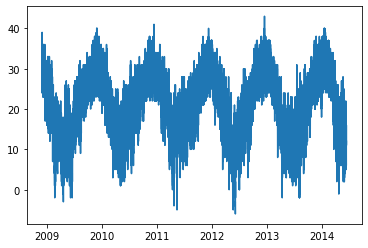

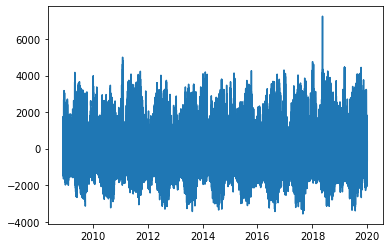

In [ ]:
dfs_stationary = dfs_stationary[dfs_stationary['Hour Ending'] >= datetime.datetime(2008, 12, 1)]
dfs_stationary = dfs_stationary[dfs_stationary['Hour Ending'] <= datetime.datetime(2020, 1, 1)]
dfs_stationary = dfs_stationary.dropna()

temperature_dfs = temperature_dfs.dropna()
temperature_dfs = temperature_dfs.reset_index(drop=True)

print(temperature_dfs.describe())
print(temperature_dfs.head())
print(dfs_stationary.describe())
print(dfs_stationary.head())
plt.plot(temperature_dfs['Hour Ending'], temperature_dfs['SCENTTEMP'])
plt.show()
plt.plot(dfs_stationary['SCENT'])

In [ ]:
print('Dickey-Fuller Test Results:')
dblcheckdfs = dfs_stationary.dropna()
dblcheckdfs = dfs_stationary.reset_index(drop=True)

for col in COLLABELS:
  if(col!='Hour Ending'):
    demand = dblcheckdfs[col]

    dftest = adfuller(demand, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(col + " Test results: ")
    print(dfoutput[0:7])

Dickey-Fuller Test Results:
COAST Test results: 
Test Statistic                   -22.838470
p-value                            0.000000
#Lags Used                        66.000000
Number of Observations Used    97074.000000
Critical Value (1%)               -3.430417
Critical Value (5%)               -2.861570
Critical Value (10%)              -2.566786
dtype: float64
EAST Test results: 
Test Statistic                   -22.717692
p-value                            0.000000
#Lags Used                        67.000000
Number of Observations Used    97073.000000
Critical Value (1%)               -3.430417
Critical Value (5%)               -2.861570
Critical Value (10%)              -2.566786
dtype: float64
FWEST Test results: 
Test Statistic                    -5.451201
p-value                            0.000003
#Lags Used                        67.000000
Number of Observations Used    97073.000000
Critical Value (1%)               -3.430417
Critical Value (5%)               -2.861570


Code below used to identify missing data

In [ ]:
pd.date_range(start = '2003-01-01', end = '2021-07-30', freq = 'h' ).difference(dfs_stationary['Hour Ending'])

DatetimeIndex(['2003-01-01 00:00:00', '2003-01-01 01:00:00',
               '2003-01-01 02:00:00', '2003-01-01 03:00:00',
               '2003-01-01 04:00:00', '2003-01-01 05:00:00',
               '2003-01-01 06:00:00', '2003-01-01 07:00:00',
               '2003-01-01 08:00:00', '2003-01-01 09:00:00',
               ...
               '2021-07-29 15:00:00', '2021-07-29 16:00:00',
               '2021-07-29 17:00:00', '2021-07-29 18:00:00',
               '2021-07-29 19:00:00', '2021-07-29 20:00:00',
               '2021-07-29 21:00:00', '2021-07-29 22:00:00',
               '2021-07-29 23:00:00', '2021-07-30 00:00:00'],
              dtype='datetime64[ns]', length=65700, freq=None)

In [ ]:
pd.date_range(start = '2003-01-01', end = '2021-07-30', freq = 'h' ).difference(dfs['Hour Ending'])

DatetimeIndex(['2003-01-01 00:00:00', '2003-04-06 02:00:00',
               '2004-04-04 02:00:00', '2005-04-03 02:00:00',
               '2006-04-02 02:00:00', '2007-03-11 02:00:00',
               '2008-03-09 02:00:00', '2009-03-08 02:00:00',
               '2010-03-14 02:00:00', '2011-03-13 02:00:00',
               '2012-03-11 02:00:00', '2013-03-10 02:00:00',
               '2014-03-09 02:00:00', '2015-03-08 02:00:00',
               '2016-03-13 02:00:00', '2017-03-12 03:00:00',
               '2018-03-11 03:00:00', '2019-03-10 03:00:00',
               '2020-03-08 03:00:00', '2021-03-14 03:00:00'],
              dtype='datetime64[ns]', freq=None)

VAR Model. Plots for each region followed by total at the end

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



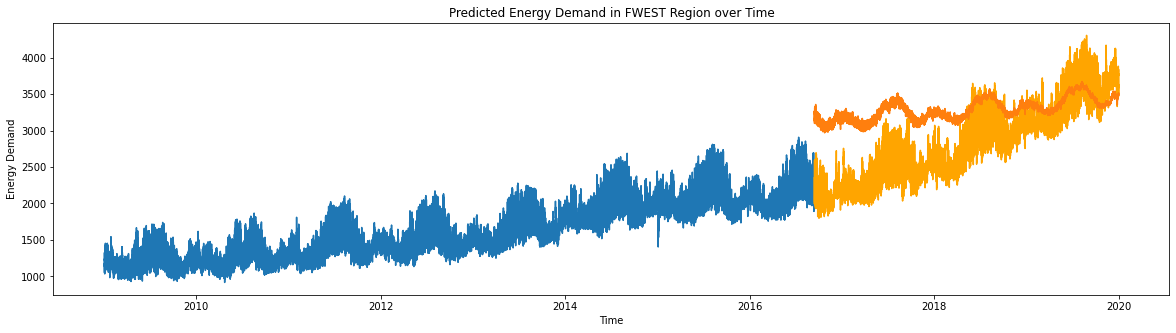

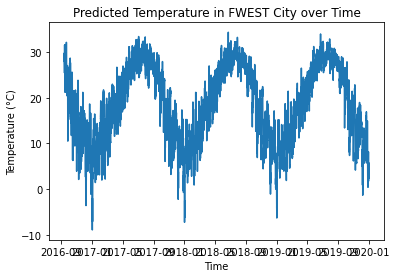

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



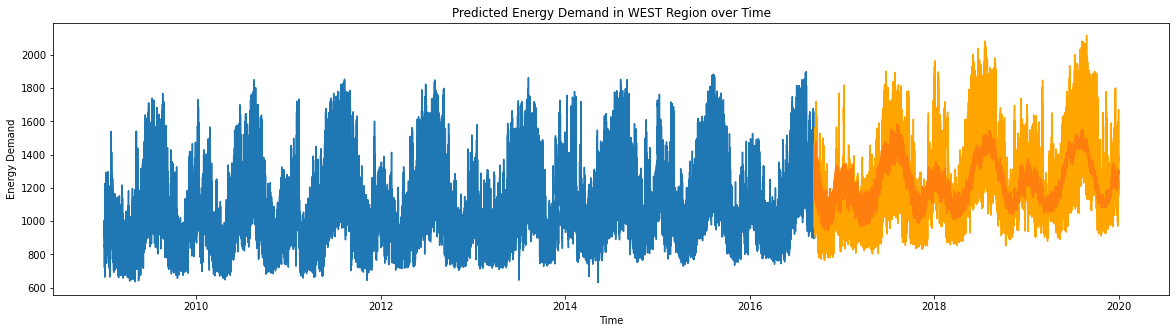

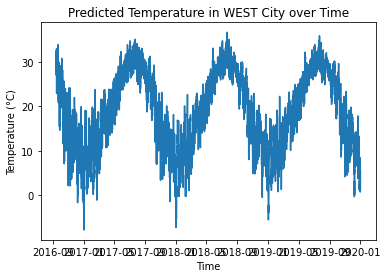

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



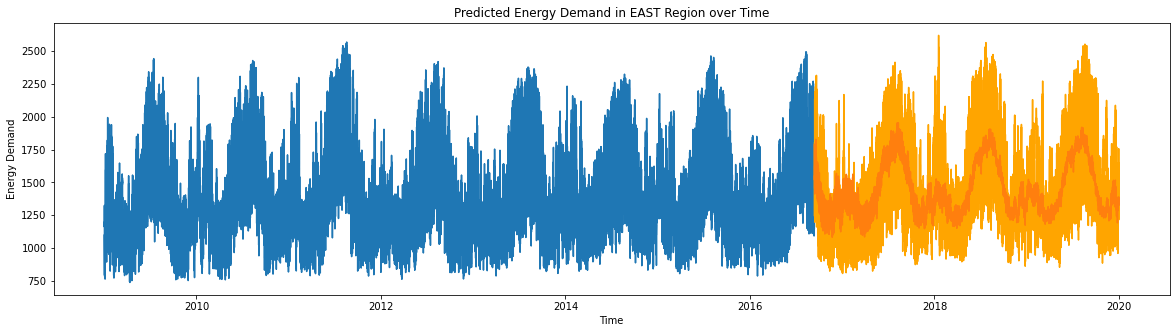

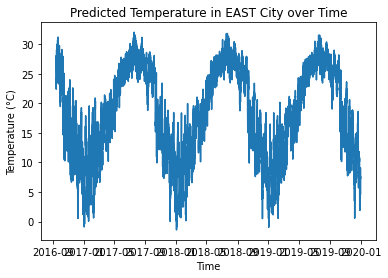

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



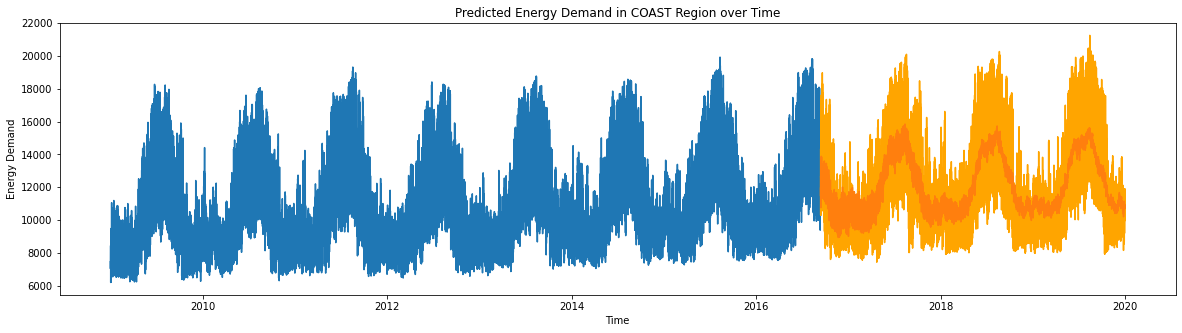

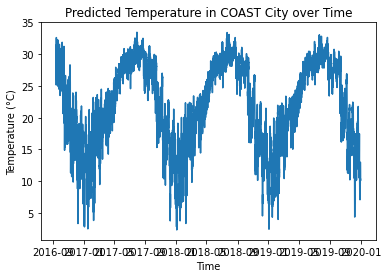

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



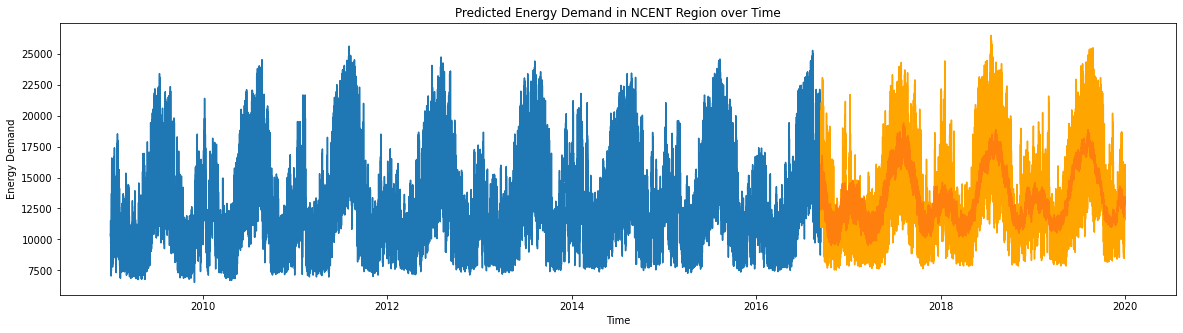

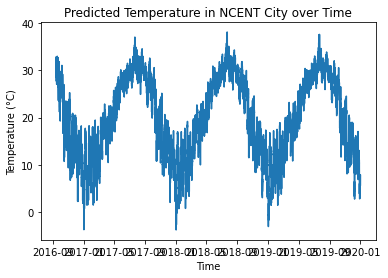

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



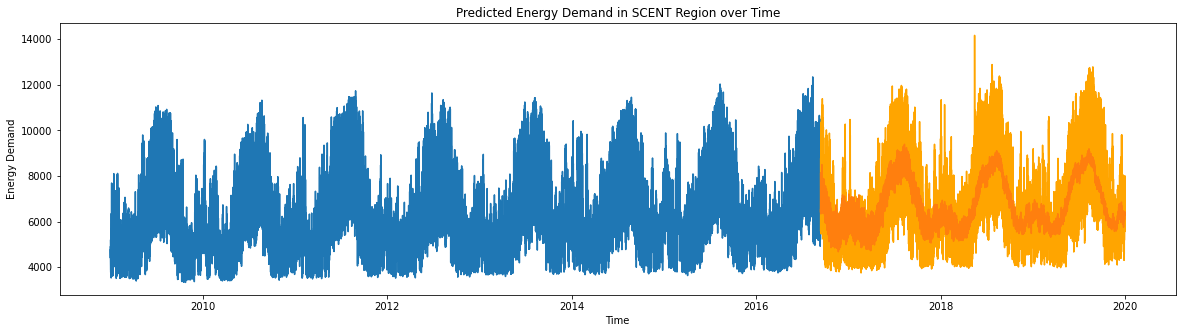

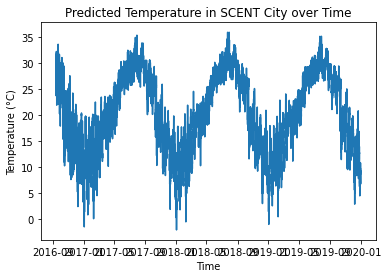

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



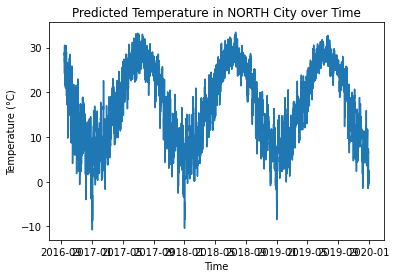

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



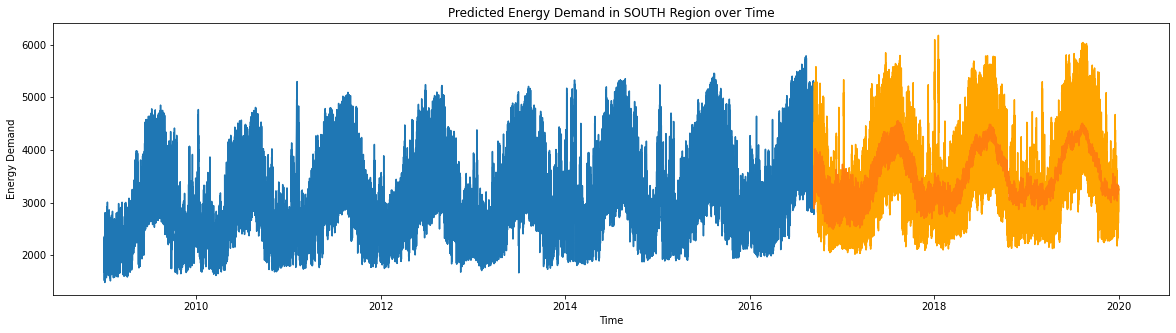

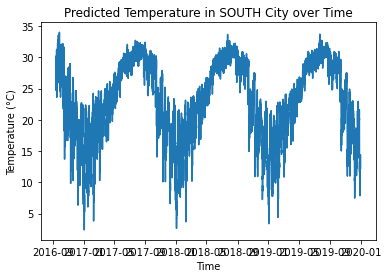

In [ ]:
#detrendedfs
#Note: 3-13-2016 2:00 is missing in the energy demand dataset.
CityRegionMap = [ ['Midland', 'FWEST'], ['Abilene', 'WEST'], ["Tyler", "EAST"], 
                 ["Houston", "COAST"], ["Dallas", "NCENT"], ["Austin", "SCENT"], 
                 ["Lubbock", "NORTH"], ["CorpusChristi", "SOUTH"]]

moredfs_stationary = dfs_stationary[dfs_stationary['Hour Ending'].dt.year > 2008]
moredfs_stationary = moredfs_stationary[moredfs_stationary['Hour Ending'].dt.year < 2020]
splitNum = int(len(moredfs_stationary) * .7)
energyTrain = moredfs_stationary[:splitNum]
energyTest = moredfs_stationary[splitNum:]
newdfs = energyTest

thenewestdfs = pd.DataFrame()

for cityMap in CityRegionMap:
  allCityTempsTwo = allCityTemps[allCityTemps['Hour Ending'].dt.year < 2020]
  allCityTempsTwo = allCityTempsTwo[allCityTemps['Hour Ending'].dt.year > 2008]
  splitNum = int(len(allCityTempsTwo) * .7)
  tempTrain = allCityTempsTwo[:splitNum]
  tempTrain = tempTrain[['Hour Ending', cityMap[0]]]
  tempTest = allCityTempsTwo[splitNum:]
  tempTest = tempTest[['Hour Ending', cityMap[0]]]
  newtemps = tempTest

  temp_seasonal_components = pd.DataFrame(index=newtemps['Hour Ending'])

  s1 = newdfs[cityMap[1]]
  s2 = newtemps[cityMap[0]]
  #remove trend/seasonalities before inputting to VAR model
  temp_daily_components = sm.tsa.seasonal_decompose(s2.values, period=24)
  temp_yearly_components = sm.tsa.seasonal_decompose(s2.values - temp_daily_components.seasonal, period=8766)
  temp_seasonal_components[cityMap[1]] = temp_yearly_components.seasonal
  s2 = s2 - temp_yearly_components.seasonal

  s1 = s1.reset_index(drop=True)
  s2 = s2.reset_index(drop=True)
  
  pairedvals = pd.DataFrame()
  pairedvals[cityMap[1]] = s1
  pairedvals[cityMap[0]] = s2

  pairedvals.index = pd.DatetimeIndex(newtemps['Hour Ending'], freq='h').difference(pd.DatetimeIndex(newtemps['Hour Ending'], freq='h').difference(newdfs['Hour Ending']))


  #Create VAR model, fit it, and plot the actual data + some analytics
  VARBivariateModel = VAR(pairedvals)
  results = VARBivariateModel.fit(maxlags=365, ic='aic')
  results.plot()
  results.plot_acorr()

  lag_order = results.k_ar

  fc = results.forecast(pairedvals.values[-lag_order:], steps=len(energyTest))
  df_forecast = pd.DataFrame(fc, index=pairedvals.index[-len(energyTest):], columns=['Energy Demand', 'Temperature'])
  
  # Reintroduce trend & seasonality
  df_forecast['Energy Demand'] = df_forecast['Energy Demand'] + energy_seasonal_components[cityMap[1]] + energy_trend_components[cityMap[1]]
  df_forecast['Temperature'] = df_forecast['Temperature'] + temp_seasonal_components[cityMap[1]]

  thenewestdfs[cityMap[1]] = df_forecast['Energy Demand']

  # Closes all the plots. We don't know what plots come before it that aren't shown
  # But whatever it is, it's messes it up real bad. Like ValueError negative datetimes bad.
  # Removing this line will cause catastrophes. We don't know why. Be cautious.
  plt.close('all')
  # Create fig and plot actual/prediction for the given region
  plt.figure(figsize=(20, 5))
  
  newerdfs = dfs[dfs['Hour Ending'].dt.year > 2008]
  newerdfs = newerdfs[newerdfs['Hour Ending'].dt.year < 2020]
  splitNum = int(len(newerdfs) * .7)
  energyTrain3 = newerdfs[:splitNum]
  energyTest3 = newerdfs[splitNum:]
  plt.plot(pd.DatetimeIndex(energyTrain3['Hour Ending']), energyTrain3[cityMap[1]], Label='Training Data')
  plt.plot(pd.DatetimeIndex(energyTest3['Hour Ending']), energyTest3[cityMap[1]], color='orange', Label='Testing Data')
  plt.plot(df_forecast['Energy Demand'])
  plt.title('Predicted Energy Demand in ' + cityMap[1] + ' Region over Time')
  plt.xlabel('Time')
  plt.ylabel('Energy Demand')
  plt.show()
  # Show temperature predictions as well
  plt.plot(df_forecast['Temperature'])
  plt.title('Predicted Temperature in ' + cityMap[1] + ' City over Time')
  plt.xlabel('Time')
  plt.ylabel('Temperature (°C)')
  plt.show()



Plot summed total of the VAR predictions to get total ERCOT grid prediction

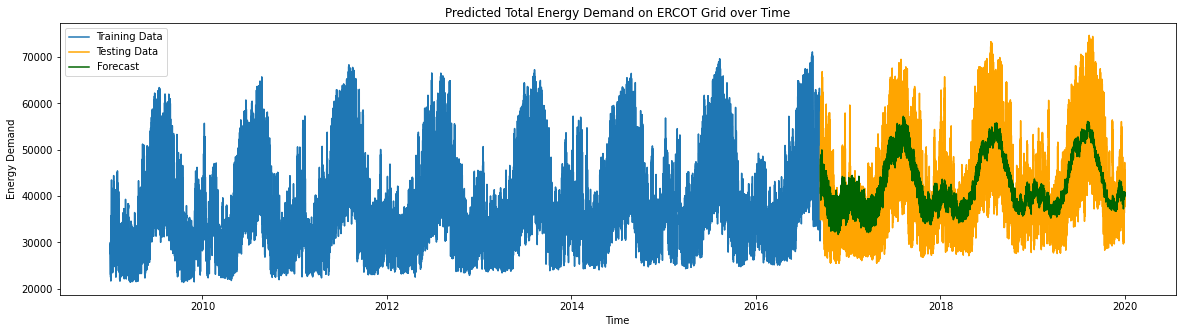

In [ ]:
moredfs_stationary = dfs[dfs['Hour Ending'].dt.year > 2008]
moredfs_stationary = moredfs_stationary[moredfs_stationary['Hour Ending'].dt.year < 2020]
splitNum = int(len(moredfs_stationary) * .7)
energyTrain = moredfs_stationary[:splitNum]
energyTest2 = moredfs_stationary[splitNum:]

plt.figure(figsize=(20, 5))
plt.plot(pd.DatetimeIndex(energyTrain['Hour Ending']), energyTrain['ERCOT'], Label='Training Data')
plt.plot(pd.DatetimeIndex(energyTest2['Hour Ending']), energyTest2['ERCOT'], color='orange', Label='Testing Data')
plt.plot(pd.DatetimeIndex(energyTest['Hour Ending']), thenewestdfs.cumsum(axis=1)['SOUTH'], color='darkgreen', Label='Forecast')
plt.legend()
plt.xlabel('Time (hourly)')
plt.ylabel('Energy Demand')
plt.title("Energy Demand over Time Prophet Model Prediction vs Test Data")

plt.title('Predicted Total Energy Demand on ERCOT Grid over Time')
plt.xlabel('Time')
plt.ylabel('Energy Demand')
plt.show()

VAR Residuals Plot

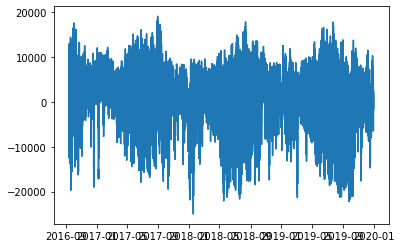

In [ ]:
energyTest2.index = pd.DatetimeIndex(energyTest2['Hour Ending'])
plt.plot(thenewestdfs.cumsum(axis=1)['SOUTH']-energyTest2['ERCOT'])

VAR RMSE

In [ ]:
evenmoredfsbecausewhynot = pd.DataFrame()
evenmoredfsbecausewhynot['ERCOT'] = energyTest2['ERCOT']
evenmoredfsbecausewhynot['Prediction'] = thenewestdfs.cumsum(axis=1)['SOUTH']
evenmoredfsbecausewhynot = evenmoredfsbecausewhynot.dropna()
rmse = np.sqrt(mean_squared_error(evenmoredfsbecausewhynot['ERCOT'], evenmoredfsbecausewhynot['Prediction']))
print(rmse)

6884.17213844736


Quick Recap of Model Accuracy
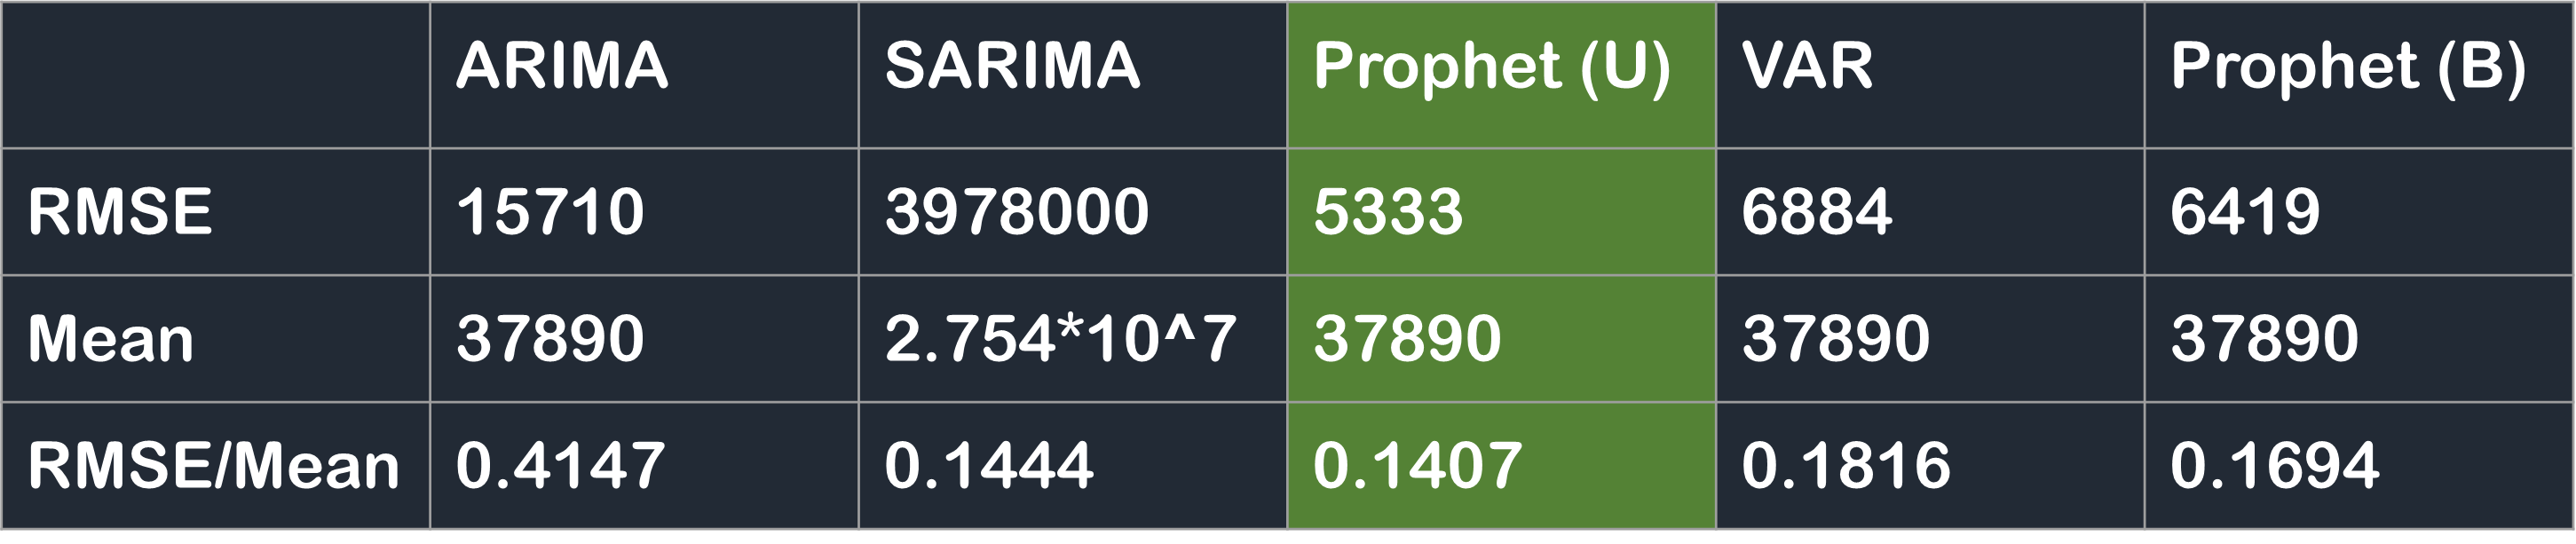

Overall, from our RMSE values, we concluded that the Prophet Univariate model performed the best. We think it comes down to 1 of the 2 following reasons:
  - Too little data (Weather data started at 2009, so bivariate model had access to 6 fewer years)
  - Too much data (Weather data is stationary, while energy demand has a slightly positive linear trend. It is possible the model formed too strong a correlation with the temperature data, and concluded that energy demand is stationary)

This marks the end of our notebook. Thanks for reading!